In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from Bio import SeqIO
from Bio.Seq import Seq

from io import StringIO
import requests
import urllib.parse
import urllib.request
import certifi
import ssl
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

# merge the different dfs

In [2]:
#these each contain optimal temperature of organisms
bacdive = pd.read_csv("Archive/bacdive_summary.csv",sep=';')
dsmz = pd.read_csv("Archive/dsmz_summary.txt", encoding='utf-16', sep='\t')
pasteur = pd.read_csv('Archive/pasteur_summary.csv')
iqui = pd.read_csv('Archive/iquibicen_summary.csv', sep=';')
nies = pd.read_csv("Archive/nies_summary.csv",sep=';')
nies.head()

,name,temp_final,dif_final,cluster
0,,20.0,1.411765,2
1,,10.0,1.250000,1
2,Acanthopeltis hirsuta,15.0,0.000000,1
3,Acaryochloris marina,25.0,0.000000,2
4,Acaryochloris tomasi,20.0,0.000000,2


In [3]:
print(len(bacdive), len(dsmz), len(pasteur), len(iqui), len(nies))
print(len(bacdive)+len(dsmz)+len(pasteur)+len(iqui)+len(nies))
merged = bacdive.merge(dsmz, on='name', how='outer')
print(len(merged))
'''
merged = merged.merge(pasteur,on='name',how='outer')
print(len(merged))
merged = merged.merge(iqui,on='name',how='outer')
print(len(merged))
merged = merged.merge(nies, on='name',how='outer')
print(len(merged))
'''
merged.head()

14641 11098 5190 166 1252
32347
16811


,name,temp_final_x,dif_final_x,cluster_x,temp_final_y,dif_final_y,cluster_y
0,Abiotrophia defectiva,37.0,0.0,2.0,37.0,0.0,2.0
1,Abyssicoccus albus,28.0,0.0,1.0,NaN,NaN,NaN
2,Abyssivirga alkaniphila,28.0,0.0,1.0,NaN,NaN,NaN
3,Acanthopleuribacter pedis,25.0,0.0,1.0,25.0,0.0,1.0
4,Acaricomes phytoseiuli,25.0,0.0,1.0,25.0,0.0,1.0


In [4]:
names = bacdive['name'].append(dsmz['name']).append(pasteur['name']).append(iqui['name']).append(nies['name'])
merged = bacdive.append(dsmz).append(pasteur).append(iqui).append(nies)
print(len(names))
print(len(set(names)))
print(len(merged))
print(len(set(merged['name'])))
merged.drop_duplicates(inplace=True)
print(len(merged))

32347
19474
32347
19474
24897


In [5]:
#some species have multiple entries; take average value and keep one
parsed = pd.DataFrame()
for ix,species in enumerate(set(merged['name'])):
    if ix % 1000 == 0:
        print('processing ix',ix,'out of',len(set(merged['name'])))
    subset = merged[merged['name']==species]
    temp = np.mean(subset['temp_final'])
    dif = np.mean(subset['dif_final'])
    parsed = parsed.append([[species,temp,dif]])
    

processing ix 0 out of 19474
processing ix 1000 out of 19474
processing ix 2000 out of 19474
processing ix 3000 out of 19474
processing ix 4000 out of 19474
processing ix 5000 out of 19474
processing ix 6000 out of 19474
processing ix 7000 out of 19474
processing ix 8000 out of 19474
processing ix 9000 out of 19474
processing ix 10000 out of 19474
processing ix 11000 out of 19474
processing ix 12000 out of 19474
processing ix 13000 out of 19474
processing ix 14000 out of 19474
processing ix 15000 out of 19474
processing ix 16000 out of 19474
processing ix 17000 out of 19474
processing ix 18000 out of 19474
processing ix 19000 out of 19474


In [6]:
parsed.columns = ['scientific_name','temp','dif']

In [7]:
print(len(parsed))
parsed.head()

19474


,scientific_name,temp,dif
0,Eupenicillium meridianum,24.0,0.0
0,Mesonia ostreae,18.0,0.0
0,Actinoplanes regularis,28.0,0.0
0,Conyzicola nivalis,20.0,0.0
0,Streptomyces paradoxus,28.0,0.0


# link names to tax ids

In [26]:
import requests

parsed['taxid'] = ''

taxa = []
problems = []
connection_errors = []

for ix,row in parsed.iterrows(): 
    if ix % 1000 == 0:
        print('processing ix',ix,'out of',len(parsed))
    species = row['scientific_name']
    url = 'https://www.ebi.ac.uk/ena/data/taxonomy/v1/taxon/scientific-name/'+str(species)
    try:
        req = requests.get(url).json()
        if len(req)>0:
            problems.append(species)

        tax = int(req[0]['taxId'])
        parsed.loc[ix,'taxid'] = tax
        taxa.append(tax)
    except:
        connection_errors.append(species)
        pass


processing ix 0 out of 19474
processing ix 1000 out of 19474
processing ix 2000 out of 19474
processing ix 3000 out of 19474
processing ix 4000 out of 19474
processing ix 5000 out of 19474
processing ix 6000 out of 19474
processing ix 7000 out of 19474
processing ix 8000 out of 19474
processing ix 9000 out of 19474
processing ix 10000 out of 19474
processing ix 11000 out of 19474
processing ix 12000 out of 19474
processing ix 13000 out of 19474
processing ix 14000 out of 19474
processing ix 15000 out of 19474
processing ix 16000 out of 19474
processing ix 17000 out of 19474
processing ix 18000 out of 19474
processing ix 19000 out of 19474


In [27]:
parsed.head()

,scientific_name,temp,dif,taxid
0,Eupenicillium meridianum,24.0,0.0,
1,Mesonia ostreae,18.0,0.0,861110
2,Actinoplanes regularis,28.0,0.0,52697
3,Conyzicola nivalis,20.0,0.0,1477021
4,Streptomyces paradoxus,28.0,0.0,66375


In [29]:
print(len(parsed))
print(len(parsed[parsed['taxid']!='']))

19474
16142


In [30]:
parsed.to_csv('merged_summary.csv',index=False)

In [4]:
parsed = pd.read_csv('merged_summary.csv')

parsed.head()

,scientific_name,temp,dif,taxid
0,Eupenicillium meridianum,24.0,0.0,NaN
1,Mesonia ostreae,18.0,0.0,861110.0
2,Actinoplanes regularis,28.0,0.0,52697.0
3,Conyzicola nivalis,20.0,0.0,1477021.0
4,Streptomyces paradoxus,28.0,0.0,66375.0


# query uniprot for housekeeping genes for taxa in parsed

In [14]:
#what are we considering 'housekeeping genes'? for now, dna and rna replication enzymes

#RNA polymerase - 2.7.7.6 
#RNA helicase - 3.6.4.13
#DNA polymerase - 2.7.7.7
#DNA primase - 2.7.7.101 (bacteria and archaea) and 2.7.7.102 (archaea)
#DNA helicase - 3.6.4.12
#DNA ligase - 6.5.1.1, 6.5.1.2, 6.5.1.6, 6.5.1.7
#topoisomerase - 5.6.2.1, 5.6.2.2

ecs = ['2.7.7.6', '3.6.4.13', '2.7.7.7', '2.7.7.101', '2.7.7.102', '3.6.4.12', '6.5.1.1', '6.5.1.2', '6.5.1.6', '6.5.1.7']

len(ecs)

10

In [100]:
#can use parentheses to do multiple OR e.g.
#https://www.uniprot.org/uniprot/?query=(ec:2.7.7.6+OR+ec:2.7.7.7)+(taxonomy:52697+OR+taxonomy:48)&format=tab&columns=id,ec,lineage-id(all)
#now need to return EC number, taxonomic id, and entry
print(ecs)
ec_query = '('+''.join(['ec:'+str(ec)+'+OR+' for ec in ecs[:-1]])+'ec:'+str(ecs[-1])+')'
taxa_list = list(set(parsed['taxid'].dropna()))
tax_query = '('+''.join(['taxonomy:'+str(int(tax))+'+OR+' for tax in taxa_list[:-1]])+'taxonomy:'+str(int(taxa_list[-1]))+')'
print(ec_query)
url = 'https://www.uniprot.org/uniprot/?query='+ec_query+'+'+tax_query+'&format=tab&columns=id,ec,lineage-id(all)'


['2.7.7.6', '3.6.4.13', '2.7.7.7', '2.7.7.101', '2.7.7.102', '3.6.4.12', '6.5.1.1', '6.5.1.2', '6.5.1.6', '6.5.1.7']
(ec:2.7.7.6+OR+ec:3.6.4.13+OR+ec:2.7.7.7+OR+ec:2.7.7.101+OR+ec:2.7.7.102+OR+ec:3.6.4.12+OR+ec:6.5.1.1+OR+ec:6.5.1.2+OR+ec:6.5.1.6+OR+ec:6.5.1.7)


In [5]:
len(set(parsed['taxid'].dropna()))

16142

In [11]:
from tqdm import tqdm
inputs = tqdm(list(set(parsed['taxid'].dropna())))
#this is super slow, figured out how to do parentheses OR statement instead, see below
#prots = pd.DataFrame()
ec_query = '('+''.join(['ec:'+str(ec)+'+OR+' for ec in ecs[:-1]])+'ec:'+str(ecs[-1])+')'
for taxa in inputs:
    #if ix % 100 == 0:
    #    print('processing ix',ix,'out of',len(set(parsed['taxid'])))
    #    print('len prots:',len(prots))
    tax = int(taxa)
    if tax not in set(prots['taxid']):
        url = 'https://www.uniprot.org/uniprot/?query='+ec_query+'+AND+taxonomy:'+str(tax)+'&format=tab&columns=id,ec'
        with requests.get(url) as r:
            req = r.text
            if len(r.text) > 0:
                data = StringIO(req)
                toadd = pd.read_csv(data, sep="\t")
                toadd['taxid'] = tax
                prots = prots.append(toadd)



  5%|▌         | 887/16142 [00:55<19:39, 12.93it/s]


  8%|▊         | 1353/16142 [01:23<12:45, 19.32it/s]


 13%|█▎        | 2151/16142 [02:20<26:53,  8.67it/s]


 17%|█▋        | 2794/16142 [03:13<19:04, 11.66it/s]


 22%|██▏       | 3486/16142 [04:10<18:16, 11.54it/s]


 26%|██▌       | 4209/16142 [05:05<10:25, 19.07it/s]


 31%|███       | 4930/16142 [06:01<15:12, 12.29it/s]


 35%|███▍      | 5583/16142 [06:56<21:59,  8.00it/s]


 39%|███▊      | 6246/16142 [07:50<12:48, 12.88it/s]


 43%|████▎     | 6943/16142 [08:46<15:19, 10.00it/s]


 47%|████▋     | 7624/16142 [09:42<12:23, 11.46it/s]


 51%|█████▏    | 8306/16142 [10:36<13:11,  9.90it/s]


 56%|█████▌    | 8981/16142 [11:49<3:35:58,  1.81s/it]


 57%|█████▋    | 9263/16142 [17:35<4:22:35,  2.29s/it]


 59%|█████▉    | 9545/16142 [23:49<1:43:57,  1.06it/s]


 61%|██████    | 9827/16142 [30:20<1:05:43,  1.60it/s]


 63%|██████▎   | 10107/16142 [36:51<1:42:09,  1.02s/it]


 64%|██████▍   | 10384/16142 [43:19<2:11:56,  1.37s/it]


 66%|██████▌   | 10662/16142 [50:12<4:50:03,  3.18s/it]


 68%|██████▊   | 10940/16142 [56:57<3:01:27,  2.09s/it]


 69%|██████▉   | 11213/16142 [1:03:28<31:00,  2.65it/s]


 71%|███████   | 11482/16142 [1:09:11<39:57,  1.94it/s]


 73%|███████▎  | 11751/16142 [1:15:46<55:12,  1.33it/s]  


 74%|███████▍  | 12019/16142 [1:23:07<1:07:22,  1.02it/s]


 76%|███████▌  | 12287/16142 [1:30:13<2:01:45,  1.90s/it]


 78%|███████▊  | 12557/16142 [1:36:49<27:49,  2.15it/s]


 79%|███████▉  | 12826/16142 [1:43:35<1:02:07,  1.12s/it]


 81%|████████  | 13096/16142 [1:50:42<57:29,  1.13s/it]  


 83%|████████▎ | 13367/16142 [1:58:13<2:45:47,  3.58s/it]


 84%|████████▍ | 13636/16142 [2:06:36<57:24,  1.37s/it]


 86%|████████▌ | 13907/16142 [2:13:55<16:47,  2.22it/s]


 88%|████████▊ | 14177/16142 [2:23:28<42:08,  1.29s/it]


 90%|████████▉ | 14451/16142 [2:29:24<14:34,  1.93it/s]


 91%|█████████ | 14726/16142 [2:36:44<1:00:42,  2.57s/it]


 93%|█████████▎| 15002/16142 [2:42:41<13:14,  1.43it/s]


 95%|█████████▍| 15278/16142 [2:48:34<42:18,  2.94s/it]


 96%|█████████▋| 15554/16142 [2:53:25<10:54,  1.11s/it]


 98%|█████████▊| 15830/16142 [2:58:54<13:36,  2.62s/it]


100%|█████████▉| 16106/16142 [3:05:39<00:35,  1.01it/s]


100%|██████████| 16142/16142 [3:06:29<00:00,  1.33it/s]

In [12]:
print(len(set(prots['taxid'])))
print(len(prots))
prots.head()

8042
421367


,Entry,EC number,taxid
0,A8HTZ1,2.7.7.6,7
1,A8HTY8,2.7.7.6,7
2,A8I0F9,2.7.7.6,7
3,A8IMA7,3.6.4.12,7
4,A8IM99,3.6.4.12,7


In [13]:
prots.to_csv('uniprot2tax2ec.csv',index=False)

In [2]:
prots = pd.read_csv('uniprot2tax2ec.csv')
print(len(set(prots['taxid'])))
print(len(prots))
prots.head()

8042
421367


,Entry,EC number,taxid
0,A8HTZ1,2.7.7.6,7
1,A8HTY8,2.7.7.6,7
2,A8I0F9,2.7.7.6,7
3,A8IMA7,3.6.4.12,7
4,A8IM99,3.6.4.12,7


In [5]:
parsed.head()

,scientific_name,temp,dif,taxid
0,Eupenicillium meridianum,24.0,0.0,NaN
1,Mesonia ostreae,18.0,0.0,861110.0
2,Actinoplanes regularis,28.0,0.0,52697.0
3,Conyzicola nivalis,20.0,0.0,1477021.0
4,Streptomyces paradoxus,28.0,0.0,66375.0


In [6]:
uniprot = prots.merge(parsed,on=['taxid'])

In [12]:
print(len(uniprot))
print(len(set(uniprot['taxid'])))
print(len(set(uniprot['Entry'])))
print(uniprot.head())
Counter(uniprot['EC number']).most_common()

421367
8042
392798
    Entry EC number  taxid           scientific_name  temp       dif
0  A8HTZ1   2.7.7.6      7  Azorhizobium caulinodans  30.0  0.777778
1  A8HTY8   2.7.7.6      7  Azorhizobium caulinodans  30.0  0.777778
2  A8I0F9   2.7.7.6      7  Azorhizobium caulinodans  30.0  0.777778
3  A8IMA7  3.6.4.12      7  Azorhizobium caulinodans  30.0  0.777778
4  A8IM99  3.6.4.12      7  Azorhizobium caulinodans  30.0  0.777778


[('3.6.4.12', 143760),
 ('2.7.7.7', 123500),
 ('2.7.7.6', 74125),
 ('3.6.4.13', 30287),
 ('6.5.1.2', 23630),
 ('3.1.-.-; 3.6.4.12', 9229),
 (nan, 8787),
 ('6.5.1.1', 5496),
 ('2.7.7.7; 3.1.11.1', 836),
 ('3.6.1.-; 3.6.4.12', 472),
 ('3.6.4.12; 5.6.2.2', 256),
 ('3.6.1.-', 198),
 ('3.1.-.-', 187),
 ('3.1.11.5', 136),
 ('3.6.1.-; 3.6.4.13', 81),
 ('3.4.23.-; 2.7.7.49; 2.7.7.7; 3.1.26.4', 49),
 ('3.4.21.-; 2.7.7.7', 40),
 ('2.7.7.7; 3.1.11.-', 33),
 ('6.5.1.6', 25),
 ('3.4.21.88', 19),
 ('3.1.22.4; 3.6.4.12', 15),
 ('2.7.7.7; 3.4.21.-', 14),
 ('3.6.5.n1', 13),
 ('6.5.1.-; 6.5.1.1', 8),
 ('3.6.4.12; 3.1.-.-', 8),
 ('2.7.7.-; 3.6.4.13', 7),
 ('6.5.1.1; 6.5.1.6; 6.5.1.7', 7),
 ('3.6.4.12; 5.6.2.1', 6),
 ('3.6.1.15; 3.6.4.12', 6),
 ('3.6.-.-; 3.6.4.12', 6),
 ('3.6.4.12; 3.6.4.13', 5),
 ('3.4.21.88; 2.7.7.7', 5),
 ('3.6.4.12; 5.99.1.2', 5),
 ('6.5.1.7', 5),
 ('3.1.21.-; 6.5.1.1', 5),
 ('5.99.1.-; 3.6.4.12', 5),
 ('2.7.7.-; 2.7.7.7', 4),
 ('3.4.21.88; 3.4.21.-; 2.7.7.7', 4),
 ('3.1.11.5; 3.6.4.

In [15]:
for ec in ecs:
    print(ec,':',len(uniprot[uniprot['EC number']==ec]))
print(ecs)

2.7.7.6 : 74125
3.6.4.13 : 30287
2.7.7.7 : 123500
2.7.7.101 : 0
2.7.7.102 : 0
3.6.4.12 : 143760
6.5.1.1 : 5496
6.5.1.2 : 23630
6.5.1.6 : 25
6.5.1.7 : 5
['2.7.7.6', '3.6.4.13', '2.7.7.7', '2.7.7.101', '2.7.7.102', '3.6.4.12', '6.5.1.1', '6.5.1.2', '6.5.1.6', '6.5.1.7']


(array([2.21000e+02, 1.19000e+02, 1.00000e+03, 1.83300e+03, 8.88000e+03,
        3.21430e+04, 1.15326e+05, 1.04170e+05, 1.42981e+05, 2.10900e+03,
        1.38100e+03, 1.75300e+03, 2.80400e+03, 1.57000e+02, 1.73800e+03,
        1.02600e+03, 1.25500e+03, 4.77000e+02, 6.28000e+02, 1.94000e+02,
        6.44000e+02, 2.33000e+02, 1.32000e+02, 1.33000e+02, 3.00000e+01]),
 array([  0.  ,   4.24,   8.48,  12.72,  16.96,  21.2 ,  25.44,  29.68,
         33.92,  38.16,  42.4 ,  46.64,  50.88,  55.12,  59.36,  63.6 ,
         67.84,  72.08,  76.32,  80.56,  84.8 ,  89.04,  93.28,  97.52,
        101.76, 106.  ]),
 <a list of 25 Patch objects>)

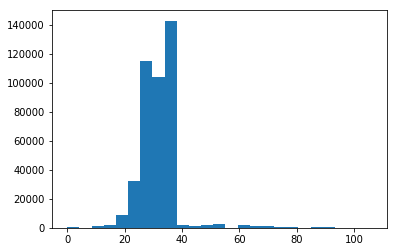

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(uniprot['temp'],bins=25)

# link to cds ids

In [63]:
#use the uniprot mapper to go from uniprotkb_id to cds id
link = pd.DataFrame()
entries = list(set(uniprot['Entry']))
step=10000
starts = list(np.arange(0,len(entries),step))
stops = list(np.arange(step,len(entries),step))+[len(entries)]

for ix in range(0,len(starts)):
    print('processing chunk',ix,'out of',len(starts))
    chunk = entries[starts[ix]:stops[ix]]
        
    url = 'https://www.uniprot.org/uploadlists/'

    query = ' '.join(chunk)
    params = { 
    'from': 'ACC+ID', #uniprot KB id
    'to': 'EMBL', #EMBL/GenBank/DDBJ CDS
    'format': 'tab', 
    'query': query
    } 

    data = urllib.parse.urlencode(params) 
    data = data.encode('utf-8') 
    req = urllib.request.Request(url, data) 
    contact=""
    req.add_header('User-Agent', 'Python %s' % contact)
    #req = urllib.request.Request(url, data, headers={'User-Agent': 'Mozilla/5.0'})
    with urllib.request.urlopen(req, context=ssl.create_default_context(cafile=certifi.where())) as f: 
        response = f.read() 

    toadd = pd.read_csv(StringIO(response.decode('utf-8')),sep='\t')
    link = link.append(toadd)


processing chunk 0 out of 40
processing chunk 1 out of 40
processing chunk 2 out of 40
processing chunk 3 out of 40
processing chunk 4 out of 40
processing chunk 5 out of 40
processing chunk 6 out of 40
processing chunk 7 out of 40
processing chunk 8 out of 40
processing chunk 9 out of 40
processing chunk 10 out of 40
processing chunk 11 out of 40
processing chunk 12 out of 40
processing chunk 13 out of 40
processing chunk 14 out of 40
processing chunk 15 out of 40
processing chunk 16 out of 40
processing chunk 17 out of 40
processing chunk 18 out of 40
processing chunk 19 out of 40
processing chunk 20 out of 40
processing chunk 21 out of 40
processing chunk 22 out of 40
processing chunk 23 out of 40
processing chunk 24 out of 40
processing chunk 25 out of 40
processing chunk 26 out of 40
processing chunk 27 out of 40
processing chunk 28 out of 40
processing chunk 29 out of 40
processing chunk 30 out of 40
processing chunk 31 out of 40
processing chunk 32 out of 40
processing chunk 33 

In [67]:
link.columns = ['Entry','EMBL_CDS_id']

In [68]:
link.to_csv('temp_uniprot2cds.tsv',index=False)

In [7]:
link = pd.read_csv('temp_uniprot2cds.tsv')

In [7]:
link.head()

,Entry,EMBL_CDS_id
0,A0A0B9A4H3,KHS53611.1
1,A0A521B2N0,SMO41364.1
2,A0A651DVI9,TVQ21103.1
3,A0A3M5W688,RMU65343.1
4,M2W5R9,EME31126.1


In [8]:
#pd.read_csv(StringIO(response),sep='\t')
#pd.read_csv(StringIO(str(response)),sep='\t')
alltemp = uniprot.merge(link,on='Entry')
alltemp.head()

,Entry,EC number,taxid,scientific_name,temp,dif,EMBL_CDS_id
0,A8HTZ1,2.7.7.6,7,Azorhizobium caulinodans,30.0,0.777778,BAF86886.1
1,A8HTY8,2.7.7.6,7,Azorhizobium caulinodans,30.0,0.777778,BAF86885.1
2,A8I0F9,2.7.7.6,7,Azorhizobium caulinodans,30.0,0.777778,BAF87251.1
3,A8IMA7,3.6.4.12,7,Azorhizobium caulinodans,30.0,0.777778,BAF86517.1
4,A8IM99,3.6.4.12,7,Azorhizobium caulinodans,30.0,0.777778,BAF86513.1


In [9]:
print(len(alltemp))
print(len(set(alltemp['EMBL_CDS_id'])))
print(len(set(alltemp['Entry'])))
print(len(set(alltemp['taxid'])))

974092
725310
392726
8042


In [19]:
print(len(set(alltemp[alltemp['EC number']=='3.6.4.13']['EMBL_CDS_id']))/len(set(alltemp['EMBL_CDS_id'])))
print(len(set(alltemp[alltemp['EC number']=='6.5.1.2']['EMBL_CDS_id']))/len(set(alltemp['EMBL_CDS_id'])))
Counter(alltemp['EC number']).most_common()[0:10]


0.11319573699521585
0.05539976010257683


[('3.6.4.12', 302995),
 ('2.7.7.7', 301118),
 ('2.7.7.6', 153023),
 ('3.6.4.13', 127463),
 ('6.5.1.2', 54346),
 ('3.1.-.-; 3.6.4.12', 11030),
 (nan, 9266),
 ('6.5.1.1', 6169),
 ('2.7.7.7; 3.4.21.-', 2721),
 ('3.4.21.-; 2.7.7.7', 1437)]

(array([1.3100e+02, 6.4800e+02, 7.4700e+03, 6.8339e+04, 5.0650e+04,
        9.0000e+01, 1.0200e+02, 2.0000e+01, 6.0000e+00, 7.0000e+00]),
 array([ 4. , 12.1, 20.2, 28.3, 36.4, 44.5, 52.6, 60.7, 68.8, 76.9, 85. ]),
 <a list of 10 Patch objects>)

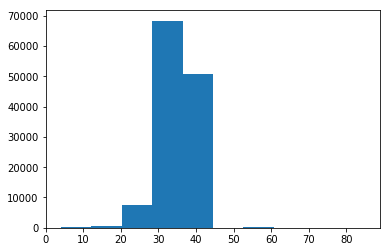

In [34]:
plt.hist(alltemp[alltemp['EC number']=='3.6.4.13']['temp'])

(array([1.0000e+00, 1.3000e+01, 3.2000e+01, 1.8000e+01, 6.8000e+01,
        3.5400e+02, 5.4300e+02, 1.4990e+03, 9.6690e+03, 1.7947e+04,
        2.3536e+04, 9.7000e+01, 4.9000e+01, 6.6000e+01, 7.3000e+01,
        2.3000e+01, 1.1900e+02, 7.5000e+01, 1.7000e+01, 5.8000e+01,
        5.9000e+01, 2.0000e+00, 1.7000e+01, 9.0000e+00, 2.0000e+00]),
 array([ 0. ,  3.4,  6.8, 10.2, 13.6, 17. , 20.4, 23.8, 27.2, 30.6, 34. ,
        37.4, 40.8, 44.2, 47.6, 51. , 54.4, 57.8, 61.2, 64.6, 68. , 71.4,
        74.8, 78.2, 81.6, 85. ]),
 <a list of 25 Patch objects>)

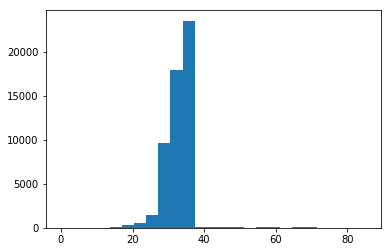

In [36]:
plt.hist(alltemp[alltemp['EC number']=='6.5.1.2']['temp'], bins=25)

# split into train/valid/test 

split on EC number; so we're mixing species across groups, *but* if want to make predictions in metagenomes need to be sure that the fact that we only used a few ECs isn't what's driving the prediction


In [10]:
valid = alltemp[alltemp['EC number']=='3.6.4.13']
test = alltemp[alltemp['EC number']=='6.5.1.2']

In [11]:
valid.head()

,Entry,EC number,taxid,scientific_name,temp,dif,EMBL_CDS_id
56,A0A5C7WNV0,3.6.4.13,17,Methylophilus methylotrophus,33.5,3.5,TXI38672.1
76,Q3A7Q6,3.6.4.13,19,Pelobacter carbinolicus,30.0,0.0,ABA87588.1
80,Q3A6L3,3.6.4.13,19,Pelobacter carbinolicus,30.0,0.0,ABA87994.1
85,A0A135I2H0,3.6.4.13,294935,Enterovibrio coralii,28.0,0.0,KXF79646.1
91,A0A135I595,3.6.4.13,294935,Enterovibrio coralii,28.0,0.0,KXF80611.1


In [12]:
print(len(alltemp))
train = alltemp.drop(valid.index)
print(len(train), len(alltemp)-len(valid))
train = train.drop(test.index)
print(len(train),len(alltemp)-len(test)-len(valid))

974092
846629 846629
792283 792283


In [13]:
print(len(set(train['EMBL_CDS_id'])))
print(len(set(valid['EMBL_CDS_id'])))
print(len(set(test['EMBL_CDS_id'])))

603026
82102
40182


In [14]:
def get_seqs(ids,fout):
    #need do it in chunks of 500
    starts = list(np.arange(0,len(ids),500))
    stops = list(np.arange(500,len(ids),500))+[len(ids)]
    root = 'https://www.ebi.ac.uk/ena/browser/api/fasta/'
    inputs = tqdm(range(0,len(starts)))

    for ix in inputs:
        try:
            url = root+','.join(ids[starts[ix]:stops[ix]])
            response = urllib.request.urlopen(url, context=ssl.create_default_context(cafile=certifi.where())).read().decode('utf-8')
            with open(fout,'a') as f:
                f.writelines(response)
        except:
            print('error, skipping ix',ix)
            pass

In [96]:
print('getting valid set temp')
get_seqs(list(set(valid['EMBL_CDS_id'])),fout='temp_valid.fasta')

print('getting test set temp')
get_seqs(list(set(test['EMBL_CDS_id'])),fout='temp_test.fasta')

print('getting train set temp')
get_seqs(list(set(train['EMBL_CDS_id'])),fout='temp_train.fasta')

getting valid set temp
getting test set temp
getting train set temp


KeyboardInterrupt: 

In [32]:
#stalled downloading train, run again here
print('getting train set temp')
get_seqs(list(set(train['EMBL_CDS_id'])),fout='temp_train2.fasta')





  0%|          | 0/1207 [00:00<?, ?it/s]

getting train set temp






  0%|          | 1/1207 [00:29<10:01:55, 29.95s/it]



  0%|          | 2/1207 [00:41<8:07:58, 24.30s/it] 

error, skipping ix 1






  0%|          | 3/1207 [01:58<13:29:12, 40.33s/it]



  0%|          | 4/1207 [03:13<16:56:10, 50.68s/it]



  0%|          | 5/1207 [04:39<20:29:32, 61.37s/it]



  0%|          | 6/1207 [05:53<21:39:37, 64.93s/it]



  1%|          | 7/1207 [07:05<22:21:14, 67.06s/it]



  1%|          | 8/1207 [08:11<22:14:01, 66.76s/it]



  1%|          | 9/1207 [09:19<22:21:19, 67.18s/it]



  1%|          | 10/1207 [10:25<22:15:32, 66.94s/it]



  1%|          | 11/1207 [11:35<22:33:16, 67.89s/it]



  1%|          | 12/1207 [12:40<22:10:22, 66.80s/it]



  1%|          | 13/1207 [13:50<22:32:57, 67.99s/it]



  1%|          | 14/1207 [15:01<22:45:51, 68.69s/it]



  1%|          | 15/1207 [16:14<23:11:26, 70.04s/it]



  1%|▏         | 16/1207 [17:23<23:01:34, 69.60s/it]



  1%|▏         | 17/1207 [18:40<23:47:22, 71.97s/it]



  1%|▏         | 18/1207 [19:26<21:10:44, 64.13s/it]

error, skipping ix 17






  2%|▏         | 19/1207 [20:30<21:11:45, 64.23s/it]



  2%|▏         | 20/1207 [21:42<21:53:21, 66.39s/it]



  2%|▏         | 21/1207 [22:48<21:50:32, 66.30s/it]



  2%|▏         | 22/1207 [23:57<22:09:13, 67.30s/it]



  2%|▏         | 23/1207 [25:01<21:46:05, 66.19s/it]



  2%|▏         | 24/1207 [26:11<22:09:30, 67.43s/it]



  2%|▏         | 25/1207 [27:18<22:05:22, 67.28s/it]



  2%|▏         | 26/1207 [27:36<17:09:30, 52.30s/it]

error, skipping ix 25






  2%|▏         | 27/1207 [28:46<18:55:49, 57.75s/it]



  2%|▏         | 28/1207 [30:05<20:57:53, 64.01s/it]



  2%|▏         | 29/1207 [31:21<22:08:17, 67.66s/it]



  2%|▏         | 30/1207 [32:35<22:46:41, 69.67s/it]



  3%|▎         | 31/1207 [33:40<22:14:01, 68.06s/it]



  3%|▎         | 32/1207 [34:52<22:39:56, 69.44s/it]



  3%|▎         | 33/1207 [36:08<23:13:20, 71.21s/it]



  3%|▎         | 34/1207 [37:27<23:59:44, 73.64s/it]



  3%|▎         | 35/1207 [38:35<23:24:47, 71.92s/it]



  3%|▎         | 36/1207 [39:43<23:00:03, 70.71s/it]



  3%|▎         | 37/1207 [40:48<22:27:53, 69.12s/it]



  3%|▎         | 38/1207 [41:54<22:05:12, 68.02s/it]



  3%|▎         | 39/1207 [42:58<21:42:22, 66.90s/it]



  3%|▎         | 40/1207 [44:01<21:18:29, 65.73s/it]



  3%|▎         | 41/1207 [45:04<21:01:27, 64.91s/it]



  3%|▎         | 42/1207 [46:07<20:51:12, 64.44s/it]



  4%|▎         | 43/1207 [47:10<20:39:50, 63.91s/it]



  4%|▎         | 44/1207 [48:10<20:16:20, 62

error, skipping ix 67






  6%|▌         | 69/1207 [1:12:19<16:12:42, 51.29s/it]



  6%|▌         | 70/1207 [1:13:13<16:29:10, 52.20s/it]



  6%|▌         | 71/1207 [1:14:10<16:52:50, 53.50s/it]



  6%|▌         | 72/1207 [1:15:10<17:30:36, 55.54s/it]



  6%|▌         | 73/1207 [1:16:06<17:29:46, 55.54s/it]



  6%|▌         | 74/1207 [1:17:05<17:50:13, 56.68s/it]



  6%|▌         | 75/1207 [1:18:01<17:44:30, 56.42s/it]



  6%|▋         | 76/1207 [1:18:58<17:50:26, 56.79s/it]



  6%|▋         | 77/1207 [1:19:53<17:37:40, 56.16s/it]



  6%|▋         | 78/1207 [1:20:48<17:29:33, 55.78s/it]



  7%|▋         | 79/1207 [1:21:43<17:25:06, 55.59s/it]



  7%|▋         | 80/1207 [1:22:39<17:24:31, 55.61s/it]



  7%|▋         | 81/1207 [1:23:42<18:09:42, 58.07s/it]



  7%|▋         | 82/1207 [1:24:41<18:11:30, 58.21s/it]



  7%|▋         | 83/1207 [1:25:41<18:20:34, 58.75s/it]



  7%|▋         | 84/1207 [1:26:36<18:00:20, 57.72s/it]



  7%|▋         | 85/1207 [1:27:32<17:45:21, 56.97s/it]



  7%|▋    

error, skipping ix 91






  8%|▊         | 93/1207 [1:34:22<14:40:09, 47.41s/it]



  8%|▊         | 94/1207 [1:35:18<15:24:19, 49.83s/it]



  8%|▊         | 95/1207 [1:36:19<16:26:19, 53.22s/it]



  8%|▊         | 96/1207 [1:37:17<16:52:51, 54.70s/it]



  8%|▊         | 97/1207 [1:38:15<17:08:19, 55.58s/it]



  8%|▊         | 98/1207 [1:39:11<17:10:03, 55.73s/it]



  8%|▊         | 99/1207 [1:40:10<17:31:38, 56.95s/it]



  8%|▊         | 100/1207 [1:41:11<17:48:59, 57.94s/it]



  8%|▊         | 101/1207 [1:42:09<17:48:46, 57.98s/it]



  8%|▊         | 102/1207 [1:43:06<17:42:01, 57.67s/it]



  9%|▊         | 103/1207 [1:44:00<17:25:06, 56.80s/it]



  9%|▊         | 104/1207 [1:44:58<17:26:02, 56.90s/it]



  9%|▊         | 105/1207 [1:45:55<17:27:07, 57.01s/it]



  9%|▉         | 106/1207 [1:46:49<17:07:56, 56.02s/it]



  9%|▉         | 107/1207 [1:47:45<17:08:17, 56.09s/it]



  9%|▉         | 108/1207 [1:48:41<17:05:48, 56.00s/it]



  9%|▉         | 109/1207 [1:49:37<17:05:19, 56.03s/it]





error, skipping ix 135






 11%|█▏        | 137/1207 [2:13:56<11:30:42, 38.73s/it]

error, skipping ix 136






 11%|█▏        | 138/1207 [2:14:46<12:32:43, 42.25s/it]



 12%|█▏        | 139/1207 [2:15:40<13:30:48, 45.55s/it]



 12%|█▏        | 140/1207 [2:16:32<14:05:39, 47.55s/it]



 12%|█▏        | 141/1207 [2:17:25<14:35:40, 49.29s/it]



 12%|█▏        | 142/1207 [2:18:19<14:58:13, 50.60s/it]



 12%|█▏        | 143/1207 [2:19:12<15:10:53, 51.37s/it]



 12%|█▏        | 144/1207 [2:20:05<15:16:46, 51.75s/it]



 12%|█▏        | 145/1207 [2:20:58<15:22:14, 52.10s/it]



 12%|█▏        | 146/1207 [2:21:51<15:26:07, 52.37s/it]



 12%|█▏        | 147/1207 [2:22:43<15:27:25, 52.50s/it]



 12%|█▏        | 148/1207 [2:23:34<15:15:03, 51.85s/it]



 12%|█▏        | 149/1207 [2:24:27<15:19:28, 52.14s/it]



 12%|█▏        | 150/1207 [2:25:19<15:18:24, 52.13s/it]



 13%|█▎        | 151/1207 [2:26:11<15:17:14, 52.12s/it]



 13%|█▎        | 152/1207 [2:27:05<15:30:12, 52.90s/it]



 13%|█▎        | 153/1207 [2:27:58<15:27:05, 52.78s/it]



 13%|█▎        | 154/1207 [2:28:48<15:10:35, 51.89s/

error, skipping ix 155






 13%|█▎        | 157/1207 [2:30:57<13:29:36, 46.26s/it]



 13%|█▎        | 158/1207 [2:31:48<13:54:24, 47.73s/it]



 13%|█▎        | 159/1207 [2:32:36<13:54:04, 47.75s/it]



 13%|█▎        | 160/1207 [2:33:27<14:11:22, 48.79s/it]



 13%|█▎        | 161/1207 [2:34:32<15:34:23, 53.60s/it]



 13%|█▎        | 162/1207 [2:35:30<15:55:12, 54.84s/it]



 14%|█▎        | 163/1207 [2:36:29<16:19:59, 56.32s/it]



 14%|█▎        | 164/1207 [2:37:26<16:19:44, 56.36s/it]



 14%|█▎        | 165/1207 [2:38:23<16:22:51, 56.59s/it]



 14%|█▍        | 166/1207 [2:38:49<13:45:07, 47.56s/it]

error, skipping ix 165






 14%|█▍        | 167/1207 [2:39:42<14:08:56, 48.98s/it]



 14%|█▍        | 168/1207 [2:40:33<14:20:10, 49.67s/it]



 14%|█▍        | 169/1207 [2:41:26<14:36:37, 50.67s/it]



 14%|█▍        | 170/1207 [2:42:23<15:06:50, 52.47s/it]



 14%|█▍        | 171/1207 [2:43:16<15:13:08, 52.88s/it]



 14%|█▍        | 172/1207 [2:44:08<15:05:10, 52.47s/it]



 14%|█▍        | 173/1207 [2:45:01<15:09:21, 52.77s/it]



 14%|█▍        | 174/1207 [2:45:56<15:19:25, 53.40s/it]



 14%|█▍        | 175/1207 [2:46:51<15:23:57, 53.72s/it]



 15%|█▍        | 176/1207 [2:47:44<15:21:15, 53.61s/it]



 15%|█▍        | 177/1207 [2:48:39<15:24:45, 53.87s/it]



 15%|█▍        | 178/1207 [2:49:32<15:23:55, 53.87s/it]



 15%|█▍        | 179/1207 [2:50:28<15:30:18, 54.30s/it]



 15%|█▍        | 180/1207 [2:51:24<15:39:13, 54.87s/it]



 15%|█▍        | 181/1207 [2:52:15<15:20:55, 53.86s/it]



 15%|█▌        | 182/1207 [2:53:10<15:24:20, 54.11s/it]



 15%|█▌        | 183/1207 [2:54:04<15:21:47, 54.01s/

error, skipping ix 216






 18%|█▊        | 218/1207 [3:23:47<11:40:21, 42.49s/it]



 18%|█▊        | 219/1207 [3:24:39<12:27:26, 45.39s/it]



 18%|█▊        | 220/1207 [3:25:35<13:16:11, 48.40s/it]



 18%|█▊        | 221/1207 [3:26:25<13:27:38, 49.15s/it]



 18%|█▊        | 222/1207 [3:27:16<13:32:53, 49.52s/it]



 18%|█▊        | 223/1207 [3:28:10<13:53:58, 50.85s/it]



 19%|█▊        | 224/1207 [3:29:02<13:59:54, 51.27s/it]



 19%|█▊        | 225/1207 [3:29:43<13:08:54, 48.20s/it]

error, skipping ix 224






 19%|█▊        | 226/1207 [3:30:38<13:40:53, 50.21s/it]



 19%|█▉        | 227/1207 [3:31:33<14:01:19, 51.51s/it]



 19%|█▉        | 228/1207 [3:32:25<14:07:42, 51.95s/it]



 19%|█▉        | 229/1207 [3:33:19<14:16:04, 52.52s/it]



 19%|█▉        | 230/1207 [3:34:14<14:27:14, 53.26s/it]



 19%|█▉        | 231/1207 [3:35:08<14:30:18, 53.50s/it]



 19%|█▉        | 232/1207 [3:35:59<14:13:10, 52.50s/it]



 19%|█▉        | 233/1207 [3:36:54<14:26:55, 53.40s/it]



 19%|█▉        | 234/1207 [3:37:51<14:45:11, 54.59s/it]



 19%|█▉        | 235/1207 [3:38:41<14:19:52, 53.08s/it]



 20%|█▉        | 236/1207 [3:39:34<14:20:49, 53.19s/it]



 20%|█▉        | 237/1207 [3:40:26<14:12:12, 52.71s/it]



 20%|█▉        | 238/1207 [3:41:21<14:19:54, 53.24s/it]



 20%|█▉        | 239/1207 [3:42:18<14:37:22, 54.38s/it]



 20%|█▉        | 240/1207 [3:43:14<14:47:52, 55.09s/it]



 20%|█▉        | 241/1207 [3:44:06<14:30:43, 54.08s/it]



 20%|██        | 242/1207 [3:44:58<14:18:16, 53.36s/

error, skipping ix 254






 21%|██        | 256/1207 [3:56:37<12:17:56, 46.56s/it]



 21%|██▏       | 257/1207 [3:57:29<12:42:52, 48.18s/it]



 21%|██▏       | 258/1207 [3:58:19<12:49:58, 48.68s/it]



 21%|██▏       | 259/1207 [3:59:14<13:19:55, 50.63s/it]



 22%|██▏       | 260/1207 [4:00:07<13:30:00, 51.32s/it]



 22%|██▏       | 261/1207 [4:01:01<13:44:14, 52.28s/it]



 22%|██▏       | 262/1207 [4:01:51<13:30:31, 51.46s/it]



 22%|██▏       | 263/1207 [4:02:41<13:24:35, 51.14s/it]



 22%|██▏       | 264/1207 [4:03:34<13:33:32, 51.76s/it]



 22%|██▏       | 265/1207 [4:03:53<10:55:48, 41.77s/it]

error, skipping ix 264






 22%|██▏       | 266/1207 [4:04:44<11:37:33, 44.48s/it]



 22%|██▏       | 267/1207 [4:05:36<12:11:30, 46.69s/it]



 22%|██▏       | 268/1207 [4:06:29<12:42:12, 48.70s/it]



 22%|██▏       | 269/1207 [4:07:19<12:46:55, 49.06s/it]



 22%|██▏       | 270/1207 [4:08:08<12:47:17, 49.13s/it]



 22%|██▏       | 271/1207 [4:09:03<13:12:26, 50.80s/it]



 23%|██▎       | 272/1207 [4:09:51<12:59:44, 50.04s/it]



 23%|██▎       | 273/1207 [4:10:38<12:43:45, 49.06s/it]



 23%|██▎       | 274/1207 [4:11:27<12:45:17, 49.22s/it]



 23%|██▎       | 275/1207 [4:12:16<12:42:52, 49.11s/it]



 23%|██▎       | 276/1207 [4:13:12<13:14:51, 51.23s/it]



 23%|██▎       | 277/1207 [4:14:05<13:19:31, 51.58s/it]



 23%|██▎       | 278/1207 [4:14:55<13:11:24, 51.11s/it]



 23%|██▎       | 279/1207 [4:15:04<9:54:41, 38.45s/it] 

error, skipping ix 278






 23%|██▎       | 280/1207 [4:15:58<11:08:42, 43.28s/it]



 23%|██▎       | 281/1207 [4:16:47<11:33:55, 44.96s/it]



 23%|██▎       | 282/1207 [4:17:39<12:04:48, 47.01s/it]



 23%|██▎       | 283/1207 [4:18:28<12:11:33, 47.50s/it]



 24%|██▎       | 284/1207 [4:19:19<12:26:25, 48.52s/it]



 24%|██▎       | 285/1207 [4:20:12<12:50:15, 50.13s/it]



 24%|██▎       | 286/1207 [4:21:04<12:57:38, 50.66s/it]



 24%|██▍       | 287/1207 [4:21:55<12:54:33, 50.52s/it]



 24%|██▍       | 288/1207 [4:22:43<12:46:30, 50.04s/it]



 24%|██▍       | 289/1207 [4:23:32<12:38:45, 49.59s/it]



 24%|██▍       | 290/1207 [4:24:20<12:29:27, 49.04s/it]



 24%|██▍       | 291/1207 [4:25:13<12:49:13, 50.39s/it]



 24%|██▍       | 292/1207 [4:26:01<12:37:15, 49.66s/it]



 24%|██▍       | 293/1207 [4:26:50<12:32:35, 49.40s/it]



 24%|██▍       | 294/1207 [4:27:39<12:30:12, 49.30s/it]



 24%|██▍       | 295/1207 [4:28:30<12:34:33, 49.64s/it]



 25%|██▍       | 296/1207 [4:29:19<12:33:00, 49.59s/

error, skipping ix 297






 25%|██▍       | 299/1207 [4:31:14<10:46:26, 42.72s/it]



 25%|██▍       | 300/1207 [4:32:03<11:15:36, 44.69s/it]



 25%|██▍       | 301/1207 [4:32:51<11:27:34, 45.53s/it]



 25%|██▌       | 302/1207 [4:33:41<11:49:51, 47.06s/it]



 25%|██▌       | 303/1207 [4:34:29<11:52:25, 47.29s/it]



 25%|██▌       | 304/1207 [4:35:22<12:15:02, 48.84s/it]



 25%|██▌       | 305/1207 [4:36:16<12:36:22, 50.31s/it]



 25%|██▌       | 306/1207 [4:37:05<12:29:54, 49.94s/it]



 25%|██▌       | 307/1207 [4:37:57<12:40:10, 50.68s/it]



 26%|██▌       | 308/1207 [4:38:49<12:47:09, 51.20s/it]



 26%|██▌       | 309/1207 [4:39:44<13:01:57, 52.25s/it]



 26%|██▌       | 310/1207 [4:40:33<12:47:55, 51.37s/it]



 26%|██▌       | 311/1207 [4:41:23<12:41:01, 50.96s/it]



 26%|██▌       | 312/1207 [4:42:15<12:44:03, 51.22s/it]



 26%|██▌       | 313/1207 [4:43:05<12:35:45, 50.72s/it]



 26%|██▌       | 314/1207 [4:43:55<12:33:30, 50.63s/it]



 26%|██▌       | 315/1207 [4:44:44<12:24:35, 50.09s/

error, skipping ix 382






 32%|███▏      | 384/1207 [5:40:57<9:34:39, 41.89s/it]



 32%|███▏      | 385/1207 [5:41:48<10:14:18, 44.84s/it]



 32%|███▏      | 386/1207 [5:42:08<8:29:21, 37.22s/it] 

error, skipping ix 385






 32%|███▏      | 387/1207 [5:42:58<9:20:59, 41.05s/it]



 32%|███▏      | 388/1207 [5:43:51<10:11:31, 44.80s/it]



 32%|███▏      | 389/1207 [5:44:43<10:39:04, 46.88s/it]



 32%|███▏      | 390/1207 [5:45:35<10:57:36, 48.29s/it]



 32%|███▏      | 391/1207 [5:46:25<11:06:33, 49.01s/it]



 32%|███▏      | 392/1207 [5:47:15<11:10:03, 49.33s/it]



 33%|███▎      | 393/1207 [5:48:07<11:18:32, 50.01s/it]



 33%|███▎      | 394/1207 [5:48:56<11:13:34, 49.71s/it]



 33%|███▎      | 395/1207 [5:49:48<11:20:13, 50.26s/it]



 33%|███▎      | 396/1207 [5:50:36<11:10:21, 49.59s/it]



 33%|███▎      | 397/1207 [5:51:26<11:10:47, 49.69s/it]



 33%|███▎      | 398/1207 [5:52:16<11:12:09, 49.85s/it]



 33%|███▎      | 399/1207 [5:53:08<11:19:30, 50.46s/it]



 33%|███▎      | 400/1207 [5:53:58<11:18:26, 50.44s/it]



 33%|███▎      | 401/1207 [5:54:10<8:43:55, 39.00s/it] 

error, skipping ix 400






 33%|███▎      | 402/1207 [5:55:00<9:26:11, 42.20s/it]



 33%|███▎      | 403/1207 [5:55:51<9:59:37, 44.75s/it]



 33%|███▎      | 404/1207 [5:56:40<10:15:34, 46.00s/it]



 34%|███▎      | 405/1207 [5:57:29<10:26:46, 46.89s/it]



 34%|███▎      | 406/1207 [5:58:15<10:22:09, 46.60s/it]



 34%|███▎      | 407/1207 [5:59:04<10:31:24, 47.36s/it]



 34%|███▍      | 408/1207 [5:59:54<10:41:48, 48.20s/it]



 34%|███▍      | 409/1207 [6:00:41<10:38:14, 47.99s/it]



 34%|███▍      | 410/1207 [6:01:28<10:31:41, 47.56s/it]



 34%|███▍      | 411/1207 [6:02:19<10:45:23, 48.65s/it]



 34%|███▍      | 412/1207 [6:03:06<10:37:54, 48.14s/it]



 34%|███▍      | 413/1207 [6:03:53<10:34:12, 47.92s/it]



 34%|███▍      | 414/1207 [6:04:41<10:32:50, 47.88s/it]



 34%|███▍      | 415/1207 [6:05:29<10:30:19, 47.75s/it]



 34%|███▍      | 416/1207 [6:06:18<10:34:37, 48.14s/it]



 35%|███▍      | 417/1207 [6:07:03<10:23:41, 47.37s/it]



 35%|███▍      | 418/1207 [6:07:49<10:15:39, 46.82s/it

error, skipping ix 422






 35%|███▌      | 424/1207 [6:12:09<9:17:38, 42.73s/it]



 35%|███▌      | 425/1207 [6:13:00<9:48:22, 45.14s/it]



 35%|███▌      | 426/1207 [6:13:49<10:02:32, 46.29s/it]



 35%|███▌      | 427/1207 [6:14:36<10:04:55, 46.53s/it]



 35%|███▌      | 428/1207 [6:15:25<10:11:57, 47.13s/it]



 36%|███▌      | 429/1207 [6:16:15<10:22:38, 48.02s/it]



 36%|███▌      | 430/1207 [6:17:05<10:30:04, 48.65s/it]



 36%|███▌      | 431/1207 [6:17:58<10:45:13, 49.89s/it]



 36%|███▌      | 432/1207 [6:18:45<10:34:44, 49.14s/it]



 36%|███▌      | 433/1207 [6:19:31<10:21:42, 48.20s/it]



 36%|███▌      | 434/1207 [6:20:18<10:15:07, 47.75s/it]



 36%|███▌      | 435/1207 [6:20:35<8:18:26, 38.74s/it] 

error, skipping ix 434






 36%|███▌      | 436/1207 [6:21:22<8:49:12, 41.18s/it]



 36%|███▌      | 437/1207 [6:22:10<9:13:42, 43.15s/it]



 36%|███▋      | 438/1207 [6:22:59<9:34:28, 44.82s/it]



 36%|███▋      | 439/1207 [6:23:47<9:47:20, 45.89s/it]



 36%|███▋      | 440/1207 [6:24:34<9:52:17, 46.33s/it]



 37%|███▋      | 441/1207 [6:25:24<10:04:16, 47.33s/it]



 37%|███▋      | 442/1207 [6:26:12<10:04:32, 47.42s/it]



 37%|███▋      | 443/1207 [6:26:59<10:04:38, 47.48s/it]



 37%|███▋      | 444/1207 [6:27:45<9:57:59, 47.02s/it] 



 37%|███▋      | 445/1207 [6:28:34<10:02:27, 47.44s/it]



 37%|███▋      | 446/1207 [6:29:19<9:55:00, 46.91s/it] 



 37%|███▋      | 447/1207 [6:30:08<9:59:38, 47.34s/it]



 37%|███▋      | 448/1207 [6:30:58<10:08:07, 48.07s/it]



 37%|███▋      | 449/1207 [6:31:42<9:52:30, 46.90s/it] 



 37%|███▋      | 450/1207 [6:32:30<9:58:58, 47.47s/it]



 37%|███▋      | 451/1207 [6:33:17<9:53:41, 47.12s/it]



 37%|███▋      | 452/1207 [6:34:08<10:07:56, 48.31s/it]



 

error, skipping ix 497






 41%|████▏     | 499/1207 [7:13:03<9:03:40, 46.07s/it]



 41%|████▏     | 500/1207 [7:13:51<9:12:14, 46.87s/it]



 42%|████▏     | 501/1207 [7:14:40<9:17:11, 47.35s/it]



 42%|████▏     | 502/1207 [7:15:28<9:20:33, 47.71s/it]



 42%|████▏     | 503/1207 [7:16:14<9:13:46, 47.20s/it]



 42%|████▏     | 504/1207 [7:17:01<9:11:29, 47.07s/it]



 42%|████▏     | 505/1207 [7:17:47<9:05:24, 46.62s/it]



 42%|████▏     | 506/1207 [7:18:30<8:53:04, 45.63s/it]



 42%|████▏     | 507/1207 [7:19:15<8:50:00, 45.43s/it]



 42%|████▏     | 508/1207 [7:20:01<8:51:52, 45.65s/it]



 42%|████▏     | 509/1207 [7:20:47<8:50:38, 45.61s/it]



 42%|████▏     | 510/1207 [7:21:08<7:26:59, 38.48s/it]

error, skipping ix 509






 42%|████▏     | 511/1207 [7:21:58<8:04:15, 41.75s/it]



 42%|████▏     | 512/1207 [7:22:44<8:20:23, 43.20s/it]



 43%|████▎     | 513/1207 [7:23:30<8:28:14, 43.94s/it]



 43%|████▎     | 514/1207 [7:24:18<8:40:23, 45.06s/it]



 43%|████▎     | 515/1207 [7:25:04<8:43:56, 45.43s/it]



 43%|████▎     | 516/1207 [7:25:51<8:49:51, 46.01s/it]



 43%|████▎     | 517/1207 [7:26:36<8:45:47, 45.72s/it]



 43%|████▎     | 518/1207 [7:27:21<8:40:29, 45.33s/it]



 43%|████▎     | 519/1207 [7:28:06<8:38:53, 45.25s/it]



 43%|████▎     | 520/1207 [7:28:54<8:46:39, 46.00s/it]



 43%|████▎     | 521/1207 [7:29:43<8:56:42, 46.94s/it]



 43%|████▎     | 522/1207 [7:30:29<8:52:17, 46.62s/it]



 43%|████▎     | 523/1207 [7:31:14<8:46:04, 46.15s/it]



 43%|████▎     | 524/1207 [7:32:01<8:50:17, 46.58s/it]



 43%|████▎     | 525/1207 [7:32:49<8:53:51, 46.97s/it]



 44%|████▎     | 526/1207 [7:33:39<9:01:05, 47.67s/it]



 44%|████▎     | 527/1207 [7:34:34<9:25:36, 49.91s/it]



 44%|████▎

error, skipping ix 547






 45%|████▌     | 549/1207 [7:52:36<8:45:37, 47.93s/it]



 46%|████▌     | 550/1207 [7:53:29<8:59:31, 49.27s/it]



 46%|████▌     | 551/1207 [7:54:14<8:44:42, 47.99s/it]



 46%|████▌     | 552/1207 [7:55:01<8:42:51, 47.90s/it]



 46%|████▌     | 553/1207 [7:55:47<8:35:29, 47.29s/it]



 46%|████▌     | 554/1207 [7:56:33<8:31:02, 46.96s/it]



 46%|████▌     | 555/1207 [7:57:19<8:26:21, 46.60s/it]



 46%|████▌     | 556/1207 [7:58:09<8:36:21, 47.59s/it]



 46%|████▌     | 557/1207 [7:59:01<8:49:51, 48.91s/it]



 46%|████▌     | 558/1207 [7:59:50<8:49:21, 48.94s/it]



 46%|████▋     | 559/1207 [8:00:37<8:40:44, 48.22s/it]



 46%|████▋     | 560/1207 [8:01:24<8:36:39, 47.91s/it]



 46%|████▋     | 561/1207 [8:02:02<8:03:26, 44.90s/it]

error, skipping ix 560






 47%|████▋     | 562/1207 [8:02:50<8:12:40, 45.83s/it]



 47%|████▋     | 563/1207 [8:03:38<8:20:25, 46.62s/it]



 47%|████▋     | 564/1207 [8:04:26<8:22:12, 46.86s/it]



 47%|████▋     | 565/1207 [8:05:16<8:34:01, 48.04s/it]



 47%|████▋     | 566/1207 [8:06:06<8:38:28, 48.53s/it]



 47%|████▋     | 567/1207 [8:06:54<8:37:04, 48.48s/it]



 47%|████▋     | 568/1207 [8:07:45<8:43:57, 49.20s/it]



 47%|████▋     | 569/1207 [8:08:31<8:33:03, 48.25s/it]



 47%|████▋     | 570/1207 [8:09:19<8:30:21, 48.07s/it]



 47%|████▋     | 571/1207 [8:10:07<8:29:40, 48.08s/it]



 47%|████▋     | 572/1207 [8:10:52<8:20:18, 47.27s/it]



 47%|████▋     | 573/1207 [8:11:39<8:18:20, 47.16s/it]



 48%|████▊     | 574/1207 [8:12:26<8:15:19, 46.95s/it]



 48%|████▊     | 575/1207 [8:13:12<8:13:20, 46.84s/it]



 48%|████▊     | 576/1207 [8:14:00<8:14:20, 47.00s/it]



 48%|████▊     | 577/1207 [8:14:45<8:07:14, 46.40s/it]



 48%|████▊     | 578/1207 [8:15:30<8:03:09, 46.09s/it]



 48%|████▊

error, skipping ix 609






 51%|█████     | 611/1207 [8:41:34<7:58:31, 48.17s/it]



 51%|█████     | 612/1207 [8:42:25<8:07:02, 49.11s/it]



 51%|█████     | 613/1207 [8:43:14<8:04:15, 48.92s/it]



 51%|█████     | 614/1207 [8:44:01<7:59:31, 48.52s/it]



 51%|█████     | 615/1207 [8:44:13<6:09:03, 37.41s/it]

error, skipping ix 614






 51%|█████     | 616/1207 [8:44:58<6:32:29, 39.85s/it]



 51%|█████     | 617/1207 [8:45:49<7:03:33, 43.07s/it]



 51%|█████     | 618/1207 [8:46:35<7:10:15, 43.83s/it]



 51%|█████▏    | 619/1207 [8:47:23<7:23:56, 45.30s/it]



 51%|█████▏    | 620/1207 [8:48:14<7:38:45, 46.89s/it]



 51%|█████▏    | 621/1207 [8:49:00<7:35:25, 46.63s/it]



 52%|█████▏    | 622/1207 [8:49:51<7:46:35, 47.86s/it]



 52%|█████▏    | 623/1207 [8:50:37<7:40:56, 47.36s/it]



 52%|█████▏    | 624/1207 [8:51:24<7:39:08, 47.25s/it]



 52%|█████▏    | 625/1207 [8:52:12<7:39:39, 47.39s/it]



 52%|█████▏    | 626/1207 [8:53:01<7:46:05, 48.13s/it]



 52%|█████▏    | 627/1207 [8:53:49<7:44:59, 48.10s/it]



 52%|█████▏    | 628/1207 [8:54:40<7:52:15, 48.94s/it]



 52%|█████▏    | 629/1207 [8:55:27<7:45:31, 48.33s/it]



 52%|█████▏    | 630/1207 [8:56:14<7:40:58, 47.94s/it]



 52%|█████▏    | 631/1207 [8:56:49<7:00:46, 43.83s/it]

error, skipping ix 630






 52%|█████▏    | 632/1207 [8:57:36<7:09:49, 44.85s/it]



 52%|█████▏    | 633/1207 [8:58:25<7:22:15, 46.23s/it]



 53%|█████▎    | 634/1207 [8:59:12<7:24:19, 46.53s/it]



 53%|█████▎    | 635/1207 [8:59:59<7:24:54, 46.67s/it]



 53%|█████▎    | 636/1207 [9:00:47<7:25:47, 46.84s/it]



 53%|█████▎    | 637/1207 [9:01:33<7:23:10, 46.65s/it]



 53%|█████▎    | 638/1207 [9:02:23<7:31:05, 47.57s/it]



 53%|█████▎    | 639/1207 [9:03:13<7:39:16, 48.51s/it]



 53%|█████▎    | 640/1207 [9:04:01<7:36:33, 48.31s/it]



 53%|█████▎    | 641/1207 [9:04:48<7:32:10, 47.93s/it]



 53%|█████▎    | 642/1207 [9:05:36<7:30:22, 47.83s/it]



 53%|█████▎    | 643/1207 [9:06:25<7:34:15, 48.33s/it]



 53%|█████▎    | 644/1207 [9:07:11<7:25:58, 47.53s/it]



 53%|█████▎    | 645/1207 [9:07:55<7:16:13, 46.57s/it]



 54%|█████▎    | 646/1207 [9:07:58<5:11:55, 33.36s/it]

error, skipping ix 645






 54%|█████▎    | 647/1207 [9:08:45<5:48:46, 37.37s/it]



 54%|█████▎    | 648/1207 [9:09:32<6:15:22, 40.29s/it]



 54%|█████▍    | 649/1207 [9:10:18<6:31:24, 42.09s/it]



 54%|█████▍    | 650/1207 [9:11:06<6:47:56, 43.94s/it]



 54%|█████▍    | 651/1207 [9:11:53<6:54:09, 44.69s/it]



 54%|█████▍    | 652/1207 [9:12:40<6:59:49, 45.39s/it]



 54%|█████▍    | 653/1207 [9:13:27<7:05:45, 46.11s/it]



 54%|█████▍    | 654/1207 [9:14:17<7:13:51, 47.07s/it]



 54%|█████▍    | 655/1207 [9:15:06<7:17:50, 47.59s/it]



 54%|█████▍    | 656/1207 [9:15:49<7:04:44, 46.25s/it]



 54%|█████▍    | 657/1207 [9:16:36<7:05:58, 46.47s/it]



 55%|█████▍    | 658/1207 [9:17:22<7:04:59, 46.45s/it]



 55%|█████▍    | 659/1207 [9:18:09<7:05:25, 46.58s/it]



 55%|█████▍    | 660/1207 [9:18:24<5:38:26, 37.12s/it]

error, skipping ix 659






 55%|█████▍    | 661/1207 [9:18:46<4:57:36, 32.70s/it]

error, skipping ix 660






 55%|█████▍    | 662/1207 [9:19:33<5:34:28, 36.82s/it]



 55%|█████▍    | 663/1207 [9:20:19<5:58:42, 39.56s/it]



 55%|█████▌    | 664/1207 [9:20:29<4:39:08, 30.84s/it]

error, skipping ix 663






 55%|█████▌    | 665/1207 [9:21:12<5:11:35, 34.49s/it]



 55%|█████▌    | 666/1207 [9:21:57<5:39:44, 37.68s/it]



 55%|█████▌    | 667/1207 [9:22:43<5:59:17, 39.92s/it]



 55%|█████▌    | 668/1207 [9:23:31<6:20:12, 42.32s/it]



 55%|█████▌    | 669/1207 [9:24:13<6:20:34, 42.44s/it]



 56%|█████▌    | 670/1207 [9:25:00<6:30:37, 43.65s/it]



 56%|█████▌    | 671/1207 [9:25:47<6:39:29, 44.72s/it]



 56%|█████▌    | 672/1207 [9:26:32<6:39:24, 44.79s/it]



 56%|█████▌    | 673/1207 [9:27:17<6:38:37, 44.79s/it]



 56%|█████▌    | 674/1207 [9:28:01<6:35:29, 44.52s/it]



 56%|█████▌    | 675/1207 [9:28:49<6:45:04, 45.69s/it]



 56%|█████▌    | 676/1207 [9:29:32<6:37:13, 44.88s/it]



 56%|█████▌    | 677/1207 [9:30:16<6:34:16, 44.63s/it]



 56%|█████▌    | 678/1207 [9:31:02<6:36:04, 44.92s/it]



 56%|█████▋    | 679/1207 [9:31:48<6:40:15, 45.48s/it]



 56%|█████▋    | 680/1207 [9:32:34<6:40:29, 45.60s/it]



 56%|█████▋    | 681/1207 [9:33:19<6:37:57, 45.39s/it]



 57%|█████

error, skipping ix 695






 58%|█████▊    | 697/1207 [9:45:25<5:26:06, 38.37s/it]



 58%|█████▊    | 698/1207 [9:46:11<5:46:10, 40.81s/it]



 58%|█████▊    | 699/1207 [9:47:02<6:09:47, 43.68s/it]



 58%|█████▊    | 700/1207 [9:47:50<6:21:38, 45.16s/it]



 58%|█████▊    | 701/1207 [9:48:39<6:30:27, 46.30s/it]



 58%|█████▊    | 702/1207 [9:49:25<6:28:52, 46.20s/it]



 58%|█████▊    | 703/1207 [9:50:11<6:27:05, 46.08s/it]



 58%|█████▊    | 704/1207 [9:51:00<6:32:09, 46.78s/it]



 58%|█████▊    | 705/1207 [9:51:44<6:24:43, 45.98s/it]



 58%|█████▊    | 706/1207 [9:51:51<4:47:55, 34.48s/it]

error, skipping ix 705






 59%|█████▊    | 707/1207 [9:52:38<5:17:33, 38.11s/it]



 59%|█████▊    | 708/1207 [9:53:22<5:32:38, 40.00s/it]



 59%|█████▊    | 709/1207 [9:54:15<6:03:26, 43.79s/it]



 59%|█████▉    | 710/1207 [9:55:01<6:08:54, 44.54s/it]



 59%|█████▉    | 711/1207 [9:55:48<6:13:33, 45.19s/it]



 59%|█████▉    | 712/1207 [9:56:33<6:13:31, 45.28s/it]



 59%|█████▉    | 713/1207 [9:57:18<6:10:07, 44.95s/it]



 59%|█████▉    | 714/1207 [9:57:30<4:47:58, 35.05s/it]

error, skipping ix 713






 59%|█████▉    | 715/1207 [9:58:16<5:14:23, 38.34s/it]



 59%|█████▉    | 716/1207 [9:59:06<5:42:22, 41.84s/it]



 59%|█████▉    | 717/1207 [9:59:53<5:56:30, 43.65s/it]



 59%|█████▉    | 718/1207 [10:00:39<6:00:59, 44.29s/it]



 60%|█████▉    | 719/1207 [10:01:26<6:05:36, 44.95s/it]



 60%|█████▉    | 720/1207 [10:02:10<6:04:08, 44.86s/it]



 60%|█████▉    | 721/1207 [10:02:58<6:08:49, 45.53s/it]



 60%|█████▉    | 722/1207 [10:03:47<6:16:36, 46.59s/it]



 60%|█████▉    | 723/1207 [10:04:32<6:13:38, 46.32s/it]



 60%|█████▉    | 724/1207 [10:05:22<6:22:12, 47.48s/it]



 60%|██████    | 725/1207 [10:06:09<6:19:09, 47.20s/it]



 60%|██████    | 726/1207 [10:06:53<6:09:48, 46.13s/it]



 60%|██████    | 727/1207 [10:07:19<5:21:41, 40.21s/it]

error, skipping ix 726






 60%|██████    | 728/1207 [10:08:05<5:35:40, 42.05s/it]



 60%|██████    | 729/1207 [10:08:48<5:36:06, 42.19s/it]



 60%|██████    | 730/1207 [10:09:31<5:38:12, 42.54s/it]



 61%|██████    | 731/1207 [10:10:12<5:33:32, 42.04s/it]

error, skipping ix 730






 61%|██████    | 732/1207 [10:10:21<4:14:03, 32.09s/it]

error, skipping ix 731






 61%|██████    | 733/1207 [10:11:05<4:41:05, 35.58s/it]



 61%|██████    | 734/1207 [10:11:49<5:00:23, 38.10s/it]



 61%|██████    | 735/1207 [10:12:35<5:19:10, 40.57s/it]



 61%|██████    | 736/1207 [10:13:19<5:25:40, 41.49s/it]



 61%|██████    | 737/1207 [10:14:03<5:30:59, 42.25s/it]



 61%|██████    | 738/1207 [10:14:45<5:31:33, 42.42s/it]



 61%|██████    | 739/1207 [10:15:32<5:39:56, 43.58s/it]



 61%|██████▏   | 740/1207 [10:16:18<5:46:13, 44.48s/it]



 61%|██████▏   | 741/1207 [10:17:06<5:52:09, 45.34s/it]



 61%|██████▏   | 742/1207 [10:17:54<5:57:58, 46.19s/it]



 62%|██████▏   | 743/1207 [10:18:37<5:49:25, 45.18s/it]



 62%|██████▏   | 744/1207 [10:19:23<5:51:37, 45.57s/it]



 62%|██████▏   | 745/1207 [10:20:12<5:57:31, 46.43s/it]



 62%|██████▏   | 746/1207 [10:20:59<5:57:54, 46.58s/it]



 62%|██████▏   | 747/1207 [10:21:46<5:58:28, 46.76s/it]



 62%|██████▏   | 748/1207 [10:22:31<5:54:40, 46.36s/it]



 62%|██████▏   | 749/1207 [10:23:15<5:49:05, 45.73s/

error, skipping ix 776






 64%|██████▍   | 778/1207 [10:45:26<5:00:13, 41.99s/it]



 65%|██████▍   | 779/1207 [10:46:15<5:12:41, 43.83s/it]



 65%|██████▍   | 780/1207 [10:47:07<5:30:18, 46.41s/it]



 65%|██████▍   | 781/1207 [10:47:56<5:35:10, 47.21s/it]



 65%|██████▍   | 782/1207 [10:48:00<4:01:39, 34.12s/it]

error, skipping ix 781






 65%|██████▍   | 783/1207 [10:48:40<4:14:52, 36.07s/it]

error, skipping ix 782






 65%|██████▍   | 784/1207 [10:49:26<4:33:58, 38.86s/it]



 65%|██████▌   | 785/1207 [10:50:11<4:47:04, 40.82s/it]



 65%|██████▌   | 786/1207 [10:50:57<4:57:54, 42.46s/it]



 65%|██████▌   | 787/1207 [10:51:49<5:15:46, 45.11s/it]



 65%|██████▌   | 788/1207 [10:52:36<5:18:48, 45.65s/it]



 65%|██████▌   | 789/1207 [10:53:23<5:21:01, 46.08s/it]



 65%|██████▌   | 790/1207 [10:54:10<5:22:50, 46.45s/it]



 66%|██████▌   | 791/1207 [10:55:02<5:33:54, 48.16s/it]



 66%|██████▌   | 792/1207 [10:55:54<5:40:12, 49.19s/it]



 66%|██████▌   | 793/1207 [10:56:25<5:01:55, 43.76s/it]

error, skipping ix 792






 66%|██████▌   | 794/1207 [10:57:12<5:07:57, 44.74s/it]



 66%|██████▌   | 795/1207 [10:57:55<5:05:09, 44.44s/it]



 66%|██████▌   | 796/1207 [10:58:43<5:11:38, 45.49s/it]



 66%|██████▌   | 797/1207 [10:59:32<5:16:48, 46.36s/it]



 66%|██████▌   | 798/1207 [11:00:20<5:19:06, 46.81s/it]



 66%|██████▌   | 799/1207 [11:01:08<5:20:43, 47.17s/it]



 66%|██████▋   | 800/1207 [11:01:54<5:18:34, 46.96s/it]



 66%|██████▋   | 801/1207 [11:02:44<5:23:03, 47.74s/it]



 66%|██████▋   | 802/1207 [11:03:33<5:25:26, 48.21s/it]



 67%|██████▋   | 803/1207 [11:04:22<5:25:55, 48.40s/it]



 67%|██████▋   | 804/1207 [11:05:08<5:19:27, 47.56s/it]



 67%|██████▋   | 805/1207 [11:05:53<5:15:19, 47.06s/it]



 67%|██████▋   | 806/1207 [11:06:40<5:13:20, 46.88s/it]



 67%|██████▋   | 807/1207 [11:07:25<5:08:28, 46.27s/it]



 67%|██████▋   | 808/1207 [11:08:12<5:08:58, 46.46s/it]



 67%|██████▋   | 809/1207 [11:08:57<5:05:11, 46.01s/it]



 67%|██████▋   | 810/1207 [11:09:44<5:06:25, 46.31s/

error, skipping ix 810






 67%|██████▋   | 812/1207 [11:10:48<4:26:06, 40.42s/it]



 67%|██████▋   | 813/1207 [11:11:33<4:34:48, 41.85s/it]



 67%|██████▋   | 814/1207 [11:12:22<4:48:34, 44.06s/it]



 68%|██████▊   | 815/1207 [11:13:08<4:52:08, 44.72s/it]



 68%|██████▊   | 816/1207 [11:13:53<4:52:13, 44.84s/it]



 68%|██████▊   | 817/1207 [11:14:41<4:57:34, 45.78s/it]



 68%|██████▊   | 818/1207 [11:15:28<4:57:40, 45.92s/it]



 68%|██████▊   | 819/1207 [11:16:13<4:55:13, 45.65s/it]



 68%|██████▊   | 820/1207 [11:16:59<4:55:09, 45.76s/it]



 68%|██████▊   | 821/1207 [11:17:46<4:56:50, 46.14s/it]



 68%|██████▊   | 822/1207 [11:18:32<4:56:10, 46.16s/it]



 68%|██████▊   | 823/1207 [11:19:18<4:55:01, 46.10s/it]



 68%|██████▊   | 824/1207 [11:20:03<4:52:17, 45.79s/it]



 68%|██████▊   | 825/1207 [11:20:50<4:53:38, 46.12s/it]



 68%|██████▊   | 826/1207 [11:21:36<4:53:55, 46.29s/it]



 69%|██████▊   | 827/1207 [11:22:31<5:08:41, 48.74s/it]



 69%|██████▊   | 828/1207 [11:23:19<5:05:51, 48.42s/

error, skipping ix 852






 71%|███████   | 854/1207 [11:43:45<3:52:38, 39.54s/it]



 71%|███████   | 855/1207 [11:44:36<4:12:17, 43.01s/it]



 71%|███████   | 856/1207 [11:44:54<3:27:53, 35.54s/it]

error, skipping ix 855






 71%|███████   | 857/1207 [11:45:27<3:23:33, 34.90s/it]

error, skipping ix 856






 71%|███████   | 858/1207 [11:46:17<3:48:09, 39.23s/it]



 71%|███████   | 859/1207 [11:47:08<4:07:55, 42.75s/it]



 71%|███████▏  | 860/1207 [11:47:59<4:21:35, 45.23s/it]



 71%|███████▏  | 861/1207 [11:48:48<4:27:31, 46.39s/it]



 71%|███████▏  | 862/1207 [11:49:37<4:32:15, 47.35s/it]



 71%|███████▏  | 863/1207 [11:50:27<4:34:55, 47.95s/it]



 72%|███████▏  | 864/1207 [11:50:37<3:30:15, 36.78s/it]

error, skipping ix 863






 72%|███████▏  | 865/1207 [11:51:26<3:49:05, 40.19s/it]



 72%|███████▏  | 866/1207 [11:52:17<4:06:50, 43.43s/it]



 72%|███████▏  | 867/1207 [11:53:04<4:12:36, 44.58s/it]



 72%|███████▏  | 868/1207 [11:53:54<4:21:49, 46.34s/it]



 72%|███████▏  | 869/1207 [11:54:45<4:28:45, 47.71s/it]



 72%|███████▏  | 870/1207 [11:55:34<4:30:46, 48.21s/it]



 72%|███████▏  | 871/1207 [11:56:21<4:27:08, 47.70s/it]



 72%|███████▏  | 872/1207 [11:57:14<4:34:59, 49.25s/it]



 72%|███████▏  | 873/1207 [11:58:00<4:28:55, 48.31s/it]



 72%|███████▏  | 874/1207 [11:58:48<4:27:50, 48.26s/it]



 72%|███████▏  | 875/1207 [11:59:39<4:30:57, 48.97s/it]



 73%|███████▎  | 876/1207 [12:00:27<4:28:52, 48.74s/it]



 73%|███████▎  | 877/1207 [12:01:15<4:26:06, 48.38s/it]



 73%|███████▎  | 878/1207 [12:02:01<4:22:56, 47.95s/it]



 73%|███████▎  | 879/1207 [12:02:49<4:21:02, 47.75s/it]



 73%|███████▎  | 880/1207 [12:03:40<4:26:01, 48.81s/it]



 73%|███████▎  | 881/1207 [12:04:26<4:20:27, 47.94s/

error, skipping ix 915






 76%|███████▌  | 917/1207 [12:31:37<3:21:33, 41.70s/it]



 76%|███████▌  | 918/1207 [12:32:25<3:30:19, 43.67s/it]



 76%|███████▌  | 919/1207 [12:33:11<3:33:40, 44.51s/it]



 76%|███████▌  | 920/1207 [12:34:06<3:46:41, 47.39s/it]



 76%|███████▋  | 921/1207 [12:34:59<3:55:16, 49.36s/it]



 76%|███████▋  | 922/1207 [12:35:47<3:52:10, 48.88s/it]



 76%|███████▋  | 923/1207 [12:36:37<3:52:16, 49.07s/it]



 77%|███████▋  | 924/1207 [12:37:27<3:52:46, 49.35s/it]



 77%|███████▋  | 925/1207 [12:38:19<3:55:21, 50.07s/it]



 77%|███████▋  | 926/1207 [12:39:09<3:55:00, 50.18s/it]



 77%|███████▋  | 927/1207 [12:39:57<3:51:06, 49.52s/it]



 77%|███████▋  | 928/1207 [12:40:52<3:57:54, 51.16s/it]



 77%|███████▋  | 929/1207 [12:41:41<3:54:03, 50.52s/it]



 77%|███████▋  | 930/1207 [12:42:30<3:50:46, 49.99s/it]



 77%|███████▋  | 931/1207 [12:43:21<3:51:09, 50.25s/it]



 77%|███████▋  | 932/1207 [12:44:09<3:47:14, 49.58s/it]



 77%|███████▋  | 933/1207 [12:44:59<3:47:05, 49.73s/

error, skipping ix 968






 80%|████████  | 970/1207 [13:13:38<2:32:15, 38.55s/it]



 80%|████████  | 971/1207 [13:14:29<2:46:12, 42.26s/it]



 81%|████████  | 972/1207 [13:15:16<2:51:32, 43.80s/it]



 81%|████████  | 973/1207 [13:15:58<2:48:59, 43.33s/it]



 81%|████████  | 974/1207 [13:16:47<2:54:41, 44.98s/it]



 81%|████████  | 975/1207 [13:17:35<2:56:29, 45.65s/it]



 81%|████████  | 976/1207 [13:18:23<2:59:09, 46.54s/it]



 81%|████████  | 977/1207 [13:19:10<2:58:35, 46.59s/it]



 81%|████████  | 978/1207 [13:19:59<3:00:25, 47.27s/it]



 81%|████████  | 979/1207 [13:20:48<3:01:47, 47.84s/it]



 81%|████████  | 980/1207 [13:21:34<2:58:40, 47.23s/it]



 81%|████████▏ | 981/1207 [13:22:17<2:53:04, 45.95s/it]



 81%|████████▏ | 982/1207 [13:23:03<2:52:19, 45.95s/it]



 81%|████████▏ | 983/1207 [13:23:47<2:50:13, 45.60s/it]



 82%|████████▏ | 984/1207 [13:24:32<2:48:40, 45.38s/it]



 82%|████████▏ | 985/1207 [13:25:18<2:48:43, 45.60s/it]



 82%|████████▏ | 986/1207 [13:26:08<2:52:56, 46.95s/

error, skipping ix 997






 83%|████████▎ | 999/1207 [13:41:27<4:13:57, 73.26s/it]



 83%|████████▎ | 1000/1207 [13:42:40<4:13:17, 73.42s/it]



 83%|████████▎ | 1001/1207 [13:43:57<4:15:32, 74.43s/it]



 83%|████████▎ | 1002/1207 [13:45:09<4:11:22, 73.57s/it]



 83%|████████▎ | 1003/1207 [13:46:23<4:11:02, 73.84s/it]



 83%|████████▎ | 1004/1207 [13:47:38<4:10:26, 74.02s/it]



 83%|████████▎ | 1005/1207 [13:48:25<3:42:25, 66.07s/it]

error, skipping ix 1004






 83%|████████▎ | 1006/1207 [13:49:35<3:44:48, 67.11s/it]



 83%|████████▎ | 1007/1207 [13:50:41<3:43:18, 66.99s/it]



 84%|████████▎ | 1008/1207 [13:51:48<3:41:41, 66.84s/it]



 84%|████████▎ | 1009/1207 [13:52:51<3:36:57, 65.74s/it]



 84%|████████▎ | 1010/1207 [13:54:03<3:42:08, 67.66s/it]



 84%|████████▍ | 1011/1207 [13:55:12<3:42:33, 68.13s/it]



 84%|████████▍ | 1012/1207 [13:56:15<3:36:27, 66.60s/it]



 84%|████████▍ | 1013/1207 [13:57:12<3:25:50, 63.66s/it]



 84%|████████▍ | 1014/1207 [13:58:16<3:25:04, 63.76s/it]



 84%|████████▍ | 1015/1207 [13:59:23<3:27:15, 64.77s/it]



 84%|████████▍ | 1016/1207 [14:00:30<3:27:40, 65.24s/it]



 84%|████████▍ | 1017/1207 [14:01:42<3:33:30, 67.42s/it]



 84%|████████▍ | 1018/1207 [14:02:49<3:32:04, 67.33s/it]



 84%|████████▍ | 1019/1207 [14:03:52<3:26:08, 65.79s/it]



 85%|████████▍ | 1020/1207 [14:04:57<3:24:49, 65.72s/it]



 85%|████████▍ | 1021/1207 [14:06:00<3:21:24, 64.97s/it]



 85%|████████▍ | 1022/1207 [14:07:03

error, skipping ix 1033






 86%|████████▌ | 1035/1207 [14:20:33<2:48:55, 58.93s/it]



 86%|████████▌ | 1036/1207 [14:21:37<2:52:07, 60.39s/it]



 86%|████████▌ | 1037/1207 [14:22:44<2:56:41, 62.36s/it]



 86%|████████▌ | 1038/1207 [14:23:53<3:01:31, 64.45s/it]



 86%|████████▌ | 1039/1207 [14:24:55<2:58:36, 63.79s/it]



 86%|████████▌ | 1040/1207 [14:25:53<2:52:38, 62.02s/it]



 86%|████████▌ | 1041/1207 [14:26:53<2:49:33, 61.28s/it]



 86%|████████▋ | 1042/1207 [14:27:56<2:50:00, 61.82s/it]



 86%|████████▋ | 1043/1207 [14:28:59<2:50:00, 62.20s/it]



 86%|████████▋ | 1044/1207 [14:29:56<2:44:31, 60.56s/it]



 87%|████████▋ | 1045/1207 [14:31:00<2:46:27, 61.65s/it]



 87%|████████▋ | 1046/1207 [14:32:02<2:46:10, 61.93s/it]



 87%|████████▋ | 1047/1207 [14:33:07<2:47:02, 62.64s/it]



 87%|████████▋ | 1048/1207 [14:34:12<2:48:19, 63.52s/it]



 87%|████████▋ | 1049/1207 [14:35:26<2:55:30, 66.65s/it]



 87%|████████▋ | 1050/1207 [14:36:26<2:49:08, 64.64s/it]



 87%|████████▋ | 1051/1207 [14:37:34

error, skipping ix 1054






 87%|████████▋ | 1056/1207 [14:42:02<2:13:38, 53.10s/it]



 88%|████████▊ | 1057/1207 [14:43:06<2:20:54, 56.36s/it]



 88%|████████▊ | 1058/1207 [14:44:18<2:31:45, 61.11s/it]



 88%|████████▊ | 1059/1207 [14:45:28<2:37:45, 63.96s/it]



 88%|████████▊ | 1060/1207 [14:46:32<2:36:44, 63.97s/it]



 88%|████████▊ | 1061/1207 [14:47:43<2:40:33, 65.98s/it]



 88%|████████▊ | 1062/1207 [14:48:45<2:36:25, 64.73s/it]



 88%|████████▊ | 1063/1207 [14:50:00<2:42:47, 67.83s/it]



 88%|████████▊ | 1064/1207 [14:51:15<2:47:07, 70.12s/it]



 88%|████████▊ | 1065/1207 [14:52:19<2:41:36, 68.29s/it]



 88%|████████▊ | 1066/1207 [14:53:30<2:42:20, 69.08s/it]



 88%|████████▊ | 1067/1207 [14:54:37<2:39:19, 68.28s/it]



 88%|████████▊ | 1068/1207 [14:55:40<2:34:18, 66.61s/it]



 89%|████████▊ | 1069/1207 [14:56:45<2:32:10, 66.16s/it]



 89%|████████▊ | 1070/1207 [14:57:46<2:27:44, 64.70s/it]



 89%|████████▊ | 1071/1207 [14:58:49<2:25:38, 64.25s/it]



 89%|████████▉ | 1072/1207 [14:59:16

error, skipping ix 1071






 89%|████████▉ | 1073/1207 [15:00:11<1:59:39, 53.58s/it]

error, skipping ix 1072






 89%|████████▉ | 1074/1207 [15:01:12<2:03:43, 55.81s/it]



 89%|████████▉ | 1075/1207 [15:02:13<2:06:15, 57.39s/it]



 89%|████████▉ | 1076/1207 [15:03:17<2:09:38, 59.37s/it]



 89%|████████▉ | 1077/1207 [15:04:19<2:10:19, 60.15s/it]



 89%|████████▉ | 1078/1207 [15:05:19<2:09:31, 60.24s/it]



 89%|████████▉ | 1079/1207 [15:06:26<2:12:23, 62.05s/it]



 89%|████████▉ | 1080/1207 [15:07:31<2:13:12, 62.93s/it]



 90%|████████▉ | 1081/1207 [15:08:54<2:25:07, 69.11s/it]



 90%|████████▉ | 1082/1207 [15:09:55<2:19:06, 66.77s/it]



 90%|████████▉ | 1083/1207 [15:10:58<2:15:14, 65.44s/it]



 90%|████████▉ | 1084/1207 [15:11:59<2:11:20, 64.07s/it]



 90%|████████▉ | 1085/1207 [15:13:03<2:10:39, 64.26s/it]



 90%|████████▉ | 1086/1207 [15:14:02<2:06:18, 62.63s/it]



 90%|█████████ | 1087/1207 [15:14:24<1:40:32, 50.27s/it]

error, skipping ix 1086






 90%|█████████ | 1088/1207 [15:15:23<1:44:51, 52.87s/it]



 90%|█████████ | 1089/1207 [15:16:26<1:50:18, 56.09s/it]



 90%|█████████ | 1090/1207 [15:17:22<1:49:20, 56.07s/it]



 90%|█████████ | 1091/1207 [15:18:22<1:50:47, 57.31s/it]



 90%|█████████ | 1092/1207 [15:19:21<1:50:21, 57.58s/it]



 91%|█████████ | 1093/1207 [15:20:17<1:48:50, 57.28s/it]



 91%|█████████ | 1094/1207 [15:21:21<1:51:44, 59.34s/it]



 91%|█████████ | 1095/1207 [15:22:23<1:52:08, 60.07s/it]



 91%|█████████ | 1096/1207 [15:23:23<1:51:17, 60.16s/it]



 91%|█████████ | 1097/1207 [15:24:19<1:47:51, 58.83s/it]



 91%|█████████ | 1098/1207 [15:25:23<1:49:35, 60.32s/it]



 91%|█████████ | 1099/1207 [15:26:21<1:47:27, 59.70s/it]



 91%|█████████ | 1100/1207 [15:27:27<1:49:43, 61.53s/it]



 91%|█████████ | 1101/1207 [15:28:26<1:47:35, 60.90s/it]



 91%|█████████▏| 1102/1207 [15:29:28<1:46:40, 60.96s/it]



 91%|█████████▏| 1103/1207 [15:30:23<1:43:02, 59.44s/it]



 91%|█████████▏| 1104/1207 [15:31:23

error, skipping ix 1150






 95%|█████████▌| 1152/1207 [16:19:58<49:04, 53.54s/it]



 96%|█████████▌| 1153/1207 [16:20:57<49:41, 55.22s/it]



 96%|█████████▌| 1154/1207 [16:21:56<49:42, 56.27s/it]



 96%|█████████▌| 1155/1207 [16:22:55<49:25, 57.02s/it]



 96%|█████████▌| 1156/1207 [16:23:50<48:05, 56.58s/it]



 96%|█████████▌| 1157/1207 [16:24:53<48:34, 58.28s/it]



 96%|█████████▌| 1158/1207 [16:25:53<48:07, 58.92s/it]



 96%|█████████▌| 1159/1207 [16:26:50<46:34, 58.22s/it]



 96%|█████████▌| 1160/1207 [16:27:53<46:55, 59.91s/it]



 96%|█████████▌| 1161/1207 [16:28:55<46:22, 60.50s/it]



 96%|█████████▋| 1162/1207 [16:30:00<46:17, 61.71s/it]



 96%|█████████▋| 1163/1207 [16:31:07<46:34, 63.50s/it]



 96%|█████████▋| 1164/1207 [16:32:21<47:41, 66.54s/it]



 97%|█████████▋| 1165/1207 [16:33:22<45:18, 64.73s/it]



 97%|█████████▋| 1166/1207 [16:34:26<44:06, 64.56s/it]



 97%|█████████▋| 1167/1207 [16:35:28<42:33, 63.83s/it]



 97%|█████████▋| 1168/1207 [16:36:12<37:33, 57.79s/it]

error, skipping ix 1167






 97%|█████████▋| 1169/1207 [16:37:08<36:18, 57.33s/it]



 97%|█████████▋| 1170/1207 [16:37:43<31:19, 50.80s/it]

error, skipping ix 1169






 97%|█████████▋| 1171/1207 [16:38:50<33:15, 55.43s/it]



 97%|█████████▋| 1172/1207 [16:39:57<34:29, 59.12s/it]



 97%|█████████▋| 1173/1207 [16:40:24<28:03, 49.52s/it]

error, skipping ix 1172






 97%|█████████▋| 1174/1207 [16:41:29<29:46, 54.14s/it]



 97%|█████████▋| 1175/1207 [16:42:32<30:16, 56.76s/it]



 97%|█████████▋| 1176/1207 [16:43:35<30:14, 58.53s/it]



 98%|█████████▊| 1177/1207 [16:44:37<29:48, 59.61s/it]



 98%|█████████▊| 1178/1207 [16:45:35<28:34, 59.11s/it]



 98%|█████████▊| 1179/1207 [16:46:41<28:32, 61.17s/it]



 98%|█████████▊| 1180/1207 [16:47:43<27:40, 61.48s/it]



 98%|█████████▊| 1181/1207 [16:48:45<26:40, 61.55s/it]



 98%|█████████▊| 1182/1207 [16:49:49<25:54, 62.18s/it]



 98%|█████████▊| 1183/1207 [16:50:54<25:18, 63.26s/it]



 98%|█████████▊| 1184/1207 [16:51:59<24:26, 63.76s/it]



 98%|█████████▊| 1185/1207 [16:52:20<18:41, 50.97s/it]

error, skipping ix 1184






 98%|█████████▊| 1186/1207 [16:53:26<19:19, 55.24s/it]



 98%|█████████▊| 1187/1207 [16:54:29<19:12, 57.65s/it]



 98%|█████████▊| 1188/1207 [16:55:42<19:44, 62.32s/it]



 99%|█████████▊| 1189/1207 [16:56:54<19:32, 65.15s/it]



 99%|█████████▊| 1190/1207 [16:57:58<18:23, 64.89s/it]



 99%|█████████▊| 1191/1207 [16:59:04<17:20, 65.05s/it]



 99%|█████████▉| 1192/1207 [17:00:06<16:04, 64.33s/it]



 99%|█████████▉| 1193/1207 [17:01:09<14:56, 64.02s/it]



 99%|█████████▉| 1194/1207 [17:02:14<13:55, 64.28s/it]



 99%|█████████▉| 1195/1207 [17:03:18<12:48, 64.08s/it]



 99%|█████████▉| 1196/1207 [17:04:20<11:37, 63.43s/it]



 99%|█████████▉| 1197/1207 [17:05:22<10:30, 63.04s/it]



 99%|█████████▉| 1198/1207 [17:06:16<09:04, 60.46s/it]



 99%|█████████▉| 1199/1207 [17:07:17<08:03, 60.40s/it]



 99%|█████████▉| 1200/1207 [17:08:20<07:08, 61.19s/it]



100%|█████████▉| 1201/1207 [17:09:18<06:01, 60.21s/it]



100%|█████████▉| 1202/1207 [17:10:15<04:56, 59.21s/it]



100%|█████

# convert to clean csv

In [24]:
def chunk_cds(seq, distrib):
    start = np.random.choice(range(0,10)) #pick first start position as somewhere near the beginning, but will only see full start codon 1/10 of the time
    chunked_seqs = []

    while start < len(seq):
        seqlen = int(np.random.choice(distrib))
        end = start+seqlen
        sequence = seq[start:end]
        if len(sequence)<60:
            start = start + seqlen
            continue
        else:
            #IRL, gene is equally likely to be sequenced in either forward or reverse direction. Use both. 
            subseq_reverse = str(Seq(sequence).reverse_complement())
            subseq_forward = sequence
            chunked_seqs.extend([subseq_forward,subseq_reverse])
            start = end

    return chunked_seqs

def create_temp_csv(outfile, ref_df, in_path, distrib):
    records = []
    #get the records and link to temp label
    for record in SeqIO.parse(in_path,"fasta"): 
        seq = str(record.seq)
        cds_id = record.description.split('|')[2].split(' ')[0]
        label = np.mean(ref_df[ref_df['EMBL_CDS_id']==cds_id]['temp']) #occasionally species and strain same gene; average value in that case
        #split into read-length chunks
        chunked_seqs = chunk_cds(seq,distrib)
        for read in chunked_seqs:        
            entry = [cds_id, read, label]
            records.append(entry)

    #shuffle records)
    outdf = pd.DataFrame(records)
    outdf = outdf.sample(frac=1)
    outdf.columns = ['EMBL_CDS_id','seq','temp']
    print('saving',len(outdf),'rows in file',outfile,':')
    print(outdf.head())
    print(np.histogram(outdf['temp']))
    outdf.to_csv(outfile,index=False)

In [16]:
distrib = np.load('../GTDBGenomeSequencingDistrib.npy')

In [25]:
valout = 'temp_valid.csv'
#save valid
create_temp_csv(outfile=valout, ref_df=valid, in_path='temp_valid.fasta', distrib=distrib)

saving 1886526 rows in file temp_valid.csv :
          EMBL_CDS_id                                                seq  \
752888   ECV1685571.1  AACGCGGTAATTATAAAGTGAAGGCGTGGCCGGCGTTAGTGGATGA...   
737678     TJF46101.1  GCTTACGGTGGTGATGGCTACGACAAACAGCTGAAAGTGCTGGAAA...   
208693   ECG4014032.1  CGCTGGCTGATGCTGGCTAAGCAACGTTTGTAGCAGCGAAATTTTT...   
1593649  EAB2399352.1  TCGGAGAACGTGGCGGAGAACAGCAGATTCTGACGCTTCGCCGGCA...   
922276     RSJ82709.1  CTCAAGAAAATCAAGATGATGAATGTTGATACTATTATCCTAGATG...   

              temp  
752888   35.250000  
737678   34.166667  
208693   35.250000  
1593649  33.500000  
922276   37.000000  
(array([   3292,   17914,  194106, 1525462,  140502,    2192,    2368,
           416,     158,     116]), array([ 4. , 12.1, 20.2, 28.3, 36.4, 44.5, 52.6, 60.7, 68.8, 76.9, 85. ]))


In [126]:
testout = 'temp_test.csv'
#save test
create_temp_csv(outfile=testout, ref_df=test, in_path='temp_test.fasta', distrib=distrib)

saving 1029424 rows in file temp_test.csv :
       EMBL_CDS_id                                                seq  \
321001  OYW74128.1  TATACTTCAGCAATCTGACGAGCAGCCTTCGCCCCAACATGACGAA...   
437264  EMD25626.1  CCCGCGGCGACGGGACCACCGGCGACGACGTGACCATGCTGGTACG...   
820845  ARM84407.1  CTCCCCGGACCTCCACCAGCTCAGGGACGTTGTTACCACGAAGTCT...   
140910  EOV05578.1  CAATCGAACAACAACTGACAGAACTGCGAACGACGCTTCGCCATCA...   
101152  PUD61244.1  CAAGTTAGTGAGTGCAACCACTAGGGGTAATGGCTTAGAAGGGGAG...   

               gh  
321001  32.333333  
437264  29.000000  
820845  25.000000  
140910  34.166667  
101152  37.000000  
Counter({35.25: 292502, 37.0: 187838, 28.0: 114956, 30.0: 105112, 33.5: 62066, 34.166666666666664: 41578, 34.666666666666664: 32072, 29.0: 23422, 29.33333333333333: 15494, 25.0: 14196, 32.333333333333336: 9398, 26.0: 8828, 22.0: 8822, 20.0: 7388, 26.5: 6802, 31.16666666666667: 5068, 28.66666666666667: 4930, 24.0: 4724, 35.0: 4558, 28.5: 4402, 27.5: 3760, 55.0: 3478, 27.0: 2918, 29.6666666666666

In [26]:
trnout = 'temp_train.csv'
#save train
create_temp_csv(outfile=trnout, ref_df=train, in_path='temp_train2.fasta', distrib=distrib)

saving 15290088 rows in file temp_train.csv :
          EMBL_CDS_id                                                seq  \
3596999    AHE66473.1  TCAAGTTCTTGTAAATAGTGTATTAATAAATTCCAAGACACCGTGC...   
4168453    EGH54236.1  CCCTCGAGCTCCAGTCGAAAGTCATAGTGCAGGTTCCGTGCGTCAT...   
4019196  EDA3847921.1  GTAAGCAAGATCGCCCGTCCGGATGCAAGCAGTGAAACACTGATTC...   
1344999  EBX5298712.1  GGAACATTTTCCGCGCCAACGCCAGGCTGTCGGTAACTTTGCAGAA...   
4425514    TCX80691.1  AAGGCATGCCGATCGCAACGCCGGTATTCGACGGTGCGAAAGAAGC...   

              temp  
3596999  37.000000  
4168453  26.000000  
4019196  35.250000  
1344999  35.250000  
4425514  34.666667  
(array([  40268,  795928, 6345198, 7791382,   80690,  119348,   69220,
         26494,   16526,    5034]), array([  4.  ,  14.05,  24.1 ,  34.15,  44.2 ,  54.25,  64.3 ,  74.35,
        84.4 ,  94.45, 104.5 ]))


# try splitting into psychro/meso/thermo philic categories

In [3]:
train = pd.read_csv('temp_train.csv')
train.head()

,EMBL_CDS_id,seq,temp
0,AHE66473.1,TCAAGTTCTTGTAAATAGTGTATTAATAAATTCCAAGACACCGTGC...,37.000000
1,EGH54236.1,CCCTCGAGCTCCAGTCGAAAGTCATAGTGCAGGTTCCGTGCGTCAT...,26.000000
2,EDA3847921.1,GTAAGCAAGATCGCCCGTCCGGATGCAAGCAGTGAAACACTGATTC...,35.250000
3,EBX5298712.1,GGAACATTTTCCGCGCCAACGCCAGGCTGTCGGTAACTTTGCAGAA...,35.250000
4,TCX80691.1,AAGGCATGCCGATCGCAACGCCGGTATTCGACGGTGCGAAAGAAGC...,34.666667


In [4]:
print(train['temp'].min())
print(train['temp'].max())

4.0
104.5


In [3]:
len(train)

15290088

In [10]:
print(len(train[train['temp']<15]))
print(len(train[train['temp']>50]))
print(len(train[(train['temp']>20)&(train['temp']<40)]))

41438
247766
14615148


In [12]:
valid = pd.read_csv('temp_valid.csv')
print(len(valid))
print(len(valid[valid['temp']<15]))
print(len(valid[valid['temp']>50]))
print(len(valid[(valid['temp']>20)&(valid['temp']<40)]))

1886526
3724
3222
1859238


In [25]:
test = pd.read_csv('temp_test.csv')
print(len(test))
print(len(test[test['temp']<15]))
print(len(test[test['temp']>50]))
print(len(test[(test['temp']>20)&(test['temp']<40)]))

1029424
2098
10860
998384


In [22]:
2000000/41438

48.26487764853516

In [24]:
200000/3724

53.70569280343717

In [27]:
100000/2098

47.66444232602478

In [30]:
def resample(df,num_rows):
    if len(df)<num_rows:
        #upsample to num_rows
        multiplier = int(num_rows/len(df))
        new_records = multiplier*[df]
    elif len(df)>=num_rows:
        #downsample to numrows
        new_records = df.sample(num_rows, replace=False)
    return new_records
    

def create_cats(df,num_rows_per_cat):
    new_df = pd.DataFrame()
    
    psychro = df[df['temp']<15]
    psychro['temp_cat'] = 'psychrophilic'
    psychro = resample(psychro,num_rows=num_rows_per_cat)
    
    meso = df[(df['temp']>20)&(df['temp']<40)]
    meso['temp_cat'] = 'mesophilic'
    meso = resample(meso,num_rows=num_rows_per_cat)
    
    thermo = df[df['temp']>50]
    thermo['temp_cat'] = 'thermophilic'
    thermo = resample(thermo,num_rows=num_rows_per_cat)
    
    new_df = new_df.append(psychro)
    new_df = new_df.append(meso)
    new_df = new_df.append(thermo)
    
    return new_df    

In [34]:
new_valid = create_cats(valid,num_rows_per_cat=200000)
print(len(new_valid))
print(Counter(new_valid['temp_cat']))
new_valid.head()

/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

597136
Counter({'mesophilic': 200000, 'thermophilic': 199764, 'psychrophilic': 197372})


,EMBL_CDS_id,seq,temp,temp_cat
167,RTR38028.1,TTGAGTTCGCAACAACACCCTCTATCGAATACTTATCTTAAACAGT...,10.0,psychrophilic
558,CBJ30797.1,CCTGGTACACTACGGAAACTTTCCCCAGCAGGTGATGGACGATGAG...,10.0,psychrophilic
1640,KGJ89102.1,GCAGCTGTTTTACCCGTACCTGTGGGGGCTGATGCTAGTACATCTT...,10.0,psychrophilic
2436,SQH78381.1,TTAGCTCTCTTTAGGAGCGCCACCTTTACGATGTGGCTTTCTGTCA...,4.0,psychrophilic
3621,CAG35627.1,TTAAGAGGTCTTTTTACGTGGCTTATATTTTTTATGGGCCACAGCT...,8.0,psychrophilic


In [35]:
new_test = create_cats(test,num_rows_per_cat=100000)
print(len(new_test))
print(Counter(new_test['temp_cat']))
new_test.head()

/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

296346
Counter({'mesophilic': 100000, 'psychrophilic': 98606, 'thermophilic': 97740})


,EMBL_CDS_id,seq,temp,temp_cat
1622,AWM31910.1,CATTGGCTGAGGTGCTGGAGTTTATCCACCAGTGGGAGAAGCAACG...,12.0,psychrophilic
1831,RTR37889.1,CTCCTGAGCGGGAAACTTAAATGCCGTAGCCCATCGGGGGGCTTTC...,10.0,psychrophilic
2149,AGI68004.1,TGGTTGGGGCGACACAAGCGTTAAGAAGCTCTGGCAAGCGGTTGAT...,4.0,psychrophilic
2529,BAJ01634.1,GTGCGCCCGACCTGAAAATCAACGCCTTCGAGTAAAGTCATCTCCT...,4.0,psychrophilic
2650,TFD78451.1,CTCCCTCCCGAGTGAATCCCTCCAGAGATCCTGTGGCCACGACCGT...,10.5,psychrophilic


In [36]:
new_train = create_cats(train,num_rows_per_cat=2000000)
print(len(new_train))
print(Counter(new_train['temp_cat']))
new_train.head()

/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/adrienne/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

5971152
Counter({'mesophilic': 2000000, 'psychrophilic': 1989024, 'thermophilic': 1982128})


,EMBL_CDS_id,seq,temp,temp_cat
758,SDM68930.1,ATTCCATTCCCGACGGATGGCCGTAAACAGTCTCAAGAACGACGCG...,10.0,psychrophilic
1512,OUR82544.1,TTAAAATGTGCCAACGTACTGATTGCCAATAATCCGCATGTGTATG...,10.0,psychrophilic
1762,ABG88855.1,CCCCATCGGTCGAGACGGAAAGATCGCCAAACCTCGTCAACTCCAC...,12.0,psychrophilic
1804,TFD80797.1,GAGATTGAAATTCACCATCCGATGGCCGGGCAGGTGTTTGTGTGCA...,10.5,psychrophilic
2105,ROM48390.1,TGAAGTACTTGGGTGAACTGCCGCGCCAGCCATAGATCGACTGCCA...,4.0,psychrophilic


In [37]:
#save to csv
new_test.to_csv('temp_test_cats.csv',index=False)
new_valid.to_csv('temp_valid_cats.csv',index=False)
new_train.to_csv('temp_train_cats.csv',index=False)

# try doing in chunks with species returned

goes faster but link to taxid is unclear

In [194]:
#doing it all at once is too big of a query for the server so we'll do it in chunks
def get_uniprotquery(ecs,taxa_list, prots, step=100):
    #need do it in chunks, let's try 1000
    starts = list(np.arange(0,len(taxa_list),step))
    stops = list(np.arange(step,len(taxa_list),step))+[len(taxa_list)]
    
    for ix in range(0,len(starts)):
        print('processing chunk',ix,'out of',len(starts))
        tax_subset = taxa_list[starts[ix]:stops[ix]]
        prots = get_uniprotquery_chunk(ecs,tax_subset,prots)
        
    return prots

def get_uniprotquery_chunk(ecs,tax_subset,prots):
    ec_query = '('+''.join(['ec:'+str(ec)+'+OR+' for ec in ecs[:-1]])+'ec:'+str(ecs[-1])+')'
    tax_query = '('+''.join(['taxonomy:'+str(int(tax))+'+OR+' for tax in tax_subset[:-1]])+'taxonomy:'+str(int(tax_subset[-1]))+')'
    url = 'https://www.uniprot.org/uniprot/?query='+ec_query+'+'+tax_query+'&format=tab&columns=id,ec,lineage-id(all),lineage-id(SPECIES)'
    with requests.get(url) as r:
            req = r.text
            print('length response',len(r.text))
            if len(r.text) > 0:
                data = StringIO(req)
                toadd = pd.read_csv(data, sep="\t")
                prots = prots.append(toadd)
                print('len prots:',len(prots))
    return prots


In [197]:
prots_with_sp = pd.DataFrame()
prots_with_sp = get_uniprotquery(ecs,taxa_list,prots_with_sp,step=200)

processing chunk 0 out of 81
length response 1276559
len prots: 16356
processing chunk 1 out of 81
length response 1585697
len prots: 36416
processing chunk 2 out of 81
length response 1793887
len prots: 61722
processing chunk 3 out of 81
length response 590677
len prots: 68878
processing chunk 4 out of 81
length response 813603
len prots: 77833
processing chunk 5 out of 81
length response 2066656
len prots: 101605
processing chunk 6 out of 81
length response 1318661
len prots: 116934
processing chunk 7 out of 81
length response 595729
len prots: 123870
processing chunk 8 out of 81
length response 366056
len prots: 128231
processing chunk 9 out of 81
length response 2287767
len prots: 158899
processing chunk 10 out of 81
length response 270651
len prots: 162205
processing chunk 11 out of 81
length response 212873
len prots: 164786
processing chunk 12 out of 81
length response 516532
len prots: 171043
processing chunk 13 out of 81
length response 269967
len prots: 174495
processing chun

In [202]:
len(prots_with_sp)
prots_with_sp.to_csv('uniprot2tax2ec2uniref_sp.csv',index=False)
prots_with_sp.head()

,Entry,EC number,Taxonomic lineage IDs (all),Taxonomic lineage IDs (SPECIES)
0,C0QVE5,6.5.1.2,"131567, 2, 203691, 203692, 1643686, 143786, 29...",159.0
1,B5Z6Y6,6.5.1.2,"131567, 2, 1224, 68525, 29547, 213849, 72293, ...",210.0
2,Q3IKB8,6.5.1.2,"131567, 2, 1224, 1236, 135622, 267888, 53246, ...",228.0
3,B2S0Q2,6.5.1.2,"131567, 2, 203691, 203692, 136, 1643685, 138, ...",140.0
4,Q3II35,2.7.7.7,"131567, 2, 1224, 1236, 135622, 267888, 53246, ...",228.0


In [3]:
prots_with_sp = pd.read_csv('uniprot2tax2ec2uniref_sp.csv')
#prots_with_sp['taxid'] = prots_with_sp['Taxonomic lineage IDs (SPECIES)'].astype(int)
prots_with_sp.head()

,Entry,EC number,Taxonomic lineage IDs (all),Taxonomic lineage IDs (SPECIES)
0,C0QVE5,6.5.1.2,"131567, 2, 203691, 203692, 1643686, 143786, 29...",159.0
1,B5Z6Y6,6.5.1.2,"131567, 2, 1224, 68525, 29547, 213849, 72293, ...",210.0
2,Q3IKB8,6.5.1.2,"131567, 2, 1224, 1236, 135622, 267888, 53246, ...",228.0
3,B2S0Q2,6.5.1.2,"131567, 2, 203691, 203692, 136, 1643685, 138, ...",140.0
4,Q3II35,2.7.7.7,"131567, 2, 1224, 1236, 135622, 267888, 53246, ...",228.0


In [4]:
parsed.head()

,scientific_name,temp,dif,taxid
0,Eupenicillium meridianum,24.0,0.0,NaN
1,Mesonia ostreae,18.0,0.0,861110.0
2,Actinoplanes regularis,28.0,0.0,52697.0
3,Conyzicola nivalis,20.0,0.0,1477021.0
4,Streptomyces paradoxus,28.0,0.0,66375.0


In [15]:
print(len(set(parsed['taxid'].dropna())))
#len(set(prots_with_sp['Taxonomic lineage IDs (SPECIES)']))
print(len(prots_with_sp))
print(len(prots_with_sp.dropna()))
print(len(set(prots_with_sp['Taxonomic lineage IDs (SPECIES)'].dropna())))
#np.histogram(prots_with_sp['Taxonomic lineage IDs (SPECIES)'])

16142


NameError: name 'prots_with_sp' is not defined

In [20]:
for taxid in list(set(parsed['taxid'].dropna()))[0:10]:
    taxid = str(int(taxid))
    print(taxid)
    print(len(prots_with_sp[prots_with_sp['Taxonomic lineage IDs (all)'].str.contains(str(int(taxid)))]))
    print(len(prots_with_sp[prots_with_sp['Taxonomic lineage IDs (SPECIES)'].astype(str).str.startswith(str(int(taxid)))]))
    print('--')

524290
0
0
--
1507331
0
0
--
7
419534
3304
--
131080
0
0
--
131081
21
0
--
327691
0
0
--
14
68783
4886
--
65552
0
0
--
65553
16
16
--
17
225243
2937
--


In [6]:
parsed[parsed['taxid']==228]

,scientific_name,temp,dif,taxid
10429,Pseudoalteromonas haloplanktis,23.333333,1.555556,228.0


In [18]:
print(len(parsed))
print(len(set(parsed['taxid'])))

19474
19474


In [176]:
print(int(prots['Taxonomic lineage IDs (all)'][0].split(', ')[-1]))
for id in prots['Taxonomic lineage IDs (all)'][0].split(', '):
    newid = int(id)
    subset = parsed[parsed['taxid']==newid]
    if len(subset)>0:
        print(subset)
        print(int(subset['taxid']))


def extract_taxid(prots,parsed):
    #look for any df longer than 0; hopefully only one
    taxids = []
    for ix,tax_candidates in enumerate(prots['Taxonomic lineage IDs (all)']):
        if ix % 10000 == 0:
            print('processing ix',ix,'out of',len(prots['Taxonomic lineage IDs (all)']))
        dfs = []
        for id in tax_candidates.split(', '):
            newid = int(id)
            subset = parsed[parsed['taxid']==newid]
            if len(subset)>0:
                dfs.append(subset)
        if len(dfs)==1: #if only one match, this is the taxid so grab it
            taxid = int(dfs[0]['taxid'])
            taxids.append(taxid)
        elif len(dfs)==0: #if it's an nan we skip
            taxids.append(np.nan)
        elif len(dfs)>1: #if there's more than one match, just record unknown and we'll deal later
            taxids.append('unknown')

    return taxids

316274
                scientific_name  temp       dif  taxid  int_taxid
7456  Herpetosiphon aurantiacus  25.0  1.666667     65       65.0
65


In [17]:
print(parsed[parsed['taxid']==24])
print(prots[prots['taxid']==24])

               scientific_name       temp       dif  taxid
17874  Shewanella putrefaciens  26.833333  1.439815   24.0
          Entry EC number  taxid
173      A4YB09  3.6.4.13     24
174      A4YBZ0   2.7.7.6     24
175      A4YBY9   2.7.7.6     24
176      A4Y6S9  3.6.4.12     24
177      A4Y6S8  3.6.4.12     24
178      A4YBV8   2.7.7.6     24
179      A4Y802   6.5.1.2     24
180      A4YBK6   2.7.7.6     24
181  A0A380AD17   2.7.7.7     24
182  A0A3S4PIN3   2.7.7.6     24
183  A0A448EN21   2.7.7.7     24
184  A0A366IT48   2.7.7.6     24
185  A0A380BXS8   2.7.7.7     24
186  A0A379ZV03  3.6.4.12     24
187  A0A366IP16   2.7.7.6     24
188  A0A448CJ65  3.6.4.12     24
189  A0A380AEJ4   2.7.7.7     24
190  A0A380A1M9  3.6.4.13     24
191  A0A366ISX6   6.5.1.2     24
192  A0A379ZK48   2.7.7.7     24
193  A0A3S4NA39  3.6.4.13     24
194  A0A379ZHC3  3.6.4.13     24
195  A0A366IYD1  3.6.4.13     24
196  A0A380AG65  3.6.4.13     24
197  A0A380A2Z8   6.5.1.2     24
198  A0A380APK0   2.7.7.